In [1]:
import argparse, os, time
import pandas as pd
import geopandas as gpd
import polars as pl
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import matplotlib.patheffects as path_effects
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict
import warnings
from tqdm import tqdm
import pickle
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tqdm.pandas()
warnings.filterwarnings("ignore")

In [2]:
year = 20
donors_csv = f"./output/donors_recip_agg_pred_lastname_trunc.csv"

In [3]:
donors = pd.read_csv(donors_csv)
donors.head(10)

contrib_id   recip_id                                           name_new  \
0             1  C60000015  republican national committee republican natio...   
1                N00000802                                                      
2             1  C60000262                  dnc general fund dnc general fund   
3             1  C60000205                                          at&t at&t   
4             1  C60000148                                          at&t at&t   
5             1  C60000080  dccc nonfederal receipts-c dccc nonfederal rec...   
6             1  C60000619    bacardi-martini usa inc bacardi-martini usa inc   
7             1  C60001450                          mci worldcom mci worldcom   
8             1  C60000247  i b e w educational committee i b e w educatio...   
9             1  C60000288  dccc nonfederal receipts-i dccc nonfederal rec...   

  realcode gender occupation        city state  total_donated  donation_count  \
0    B1500               NaN  WASHINGTON    DC     77820848.0            4793   
1    Z9000               NaN         NaN           72634500.0              75   
2    K1000               NaN  WASHINGTON    DC     40192970.0            2247   
3    B1500               NaN  WASHINGTON    DC     32889365.0            9112   
4    H4300               NaN  WASHINGTON    DC     30116512.0            2572   
5    Z9100               NaN  WASHINGTON    DC     22149421.0             545   
6    K1000               NaN  WASHINGTON    DC     20752086.0             963   
7    K1000               NaN  WASHINGTON    DC     16237657.0            1559   
8    LB100               NaN  WASHINGTON    DC     13487450.0             217   
9    Z9100               NaN  WASHINGTON    DC      9651243.0              48   

   ...  seat  ran_general type    cmte_id  \
0  ...   NaN          NaN  NaN  C60000015   
1  ...  PRES                 O        NaN   
2  ...   NaN          NaN  NaN  C60000262   
3  ...   NaN          NaN  NaN  C60000205   
4  ...   NaN          NaN  NaN  C60000148   
5  ...   NaN          NaN  NaN  C60000080   
6  ...   NaN          NaN  NaN  C60000619   
7  ...   NaN          NaN  NaN  C60001450   
8  ...   NaN          NaN  NaN  C60000247   
9  ...   NaN          NaN  NaN  C60000288   

                                 pac_short  recip_id_pac cand_id recip_is_pac  \
0  RNC/Repub National State Elections Cmte     C60000015     NaN         True   
1                                      NaN           NaN     NaN        False   
2                DNC/Non-Federal Corporate     C60000262     NaN         True   
3                         NRCC/Non-Federal     C60000205     NaN         True   
4                         NRSC/Non-Federal     C60000148     NaN         True   
5               DCCC/Non-Federal Account 1     C60000080     NaN         True   
6               DSCC/Non-Federal Corporate     C60000619     NaN         True   
7               DCCC/Non-Federal Account 1     C60001450     NaN         True   
8                  DNC/Non-Federal General     C60000247     NaN         True   
9               DCCC/Non-Federal Account 5     C60000288     NaN         True   

  dem_ratio      level  
0       NaN        PAC  
1 -0.420059  President  
2       NaN        PAC  
3       NaN        PAC  
4       NaN        PAC  
5       NaN        PAC  
6       NaN        PAC  
7       NaN        PAC  
8       NaN        PAC  
9       NaN        PAC  

[10 rows x 28 columns]

In [4]:
donors["level"].value_counts()

level
PAC          14768809
House        13329955
President     4432438
Unknown         18200
Name: count, dtype: int64

In [5]:
donors["party"].value_counts()

party
D    13537717
R    12154046
I      310080
3       39094
L       17500
U         137
Name: count, dtype: int64

In [6]:
donors[["recip_id", "name_y"]].value_counts()

recip_id   name_y                               
C00003418  Republican National Cmte                 1593676
C00694323  WinRed                                    994887
N00001669  Joe Biden (D)                             863872
N00023864  Donald Trump (R)                          819862
C00010603  DNC Services Corp                         809651
                                                     ...   
C00714139  Dump the Chump                                 1
C00714113  Big Tree PAC                                   1
C00714097  Blake Harrison Victory Fund                    1
C00713834  Outraise PAC                                   1
C00782490  Americans for Conservative Government          1
Name: count, Length: 34047, dtype: int64

In [7]:
donors["seat"].value_counts()

seat
PRES    4432438
VTS1     493932
GAS2     401963
TXS2     256932
MAS1     241500
         ...   
CA00          5
TX00          5
SC00          3
ASAS          2
              1
Name: count, Length: 578, dtype: int64

In [8]:
donors[donors["indian"] == True]["seat"].value_counts()

seat
PRES    47300
IL08     6774
VTS1     6061
NYS1     4359
GAS2     3349
        ...  
PA20        3
MI16        1
OK06        1
OH19        1
NY31        1
Name: count, Length: 571, dtype: int64

In [9]:
donors[donors["indian"] == True].sort_values(by="total_donated", ascending=False).head(10)[["contrib_id", "recip_id", "name_new", "realcode", "gender", "occupation", "city", "state", "total_donated", "name_y", "party", "seat", "type"]]

contrib_id   recip_id            name_new realcode gender  \
16285911  h3003465387   N00041034  shiva dr ayyadurai    Z9000      M   
26570010  U0000004761   C00473918        nishad singh    F2800      M   
26570051  U0000004761   C00484642        nishad singh    F2800      M   
12402789  U0000003169   C00495861     philip r munger    F7000      M   
26570199  U0000004761   C00476978        nishad singh    F2800      M   
19433829  h3003465387   N00041034     shiva ayyadurai    Z9000      U   
12402885  U0000004554   C00582841     vivek garipalli    H2100      M   
26570310  U0000004761   C00683649        nishad singh    F2800      M   
26570282  U0000004761   C00801514        nishad singh    F2800      M   
26570239  U00000033011  C00484642        vinod khosla    F2500      M   

                       occupation                     city state  \
16285911           CHAIRMAN & CEO                CAMBRIDGE    MA   
26570010  DIRECTOR OF ENGINEERING  NEW PROVIDENCE, BAHAMAS   NaN   
26570051  DIRECTOR OF ENGINEERING          LOS ALTOS HILLS    CA   
12402789                 INVESTOR                 NEW YORK    NY   
26570199  DIRECTOR OF ENGINEERING                   NASSAU   NaN   
19433829           CHAIRMAN & CEO                  BELMONT    MA   
12402885                EXECUTIVE               WILMINGTON    DE   
26570310             ENTREPRENEUR                 SARATOGA    CA   
26570282  DIRECTOR OF ENGINEERING          NASSAU, BAHAMAS   NaN   
26570239       VENTURE CAPITALIST               MENLO PARK    CA   

          total_donated                  name_y party  seat type  
16285911      4817653.0     Shiva Ayyadurai (I)     I  MAS1    C  
26570010      2250000.0             Women Vote!   NaN   NaN  NaN  
26570051      2000000.0     Senate Majority PAC     D   NaN  NaN  
12402789      1850000.0   Priorities USA Action   NaN   NaN  NaN  
26570199      1100000.0      LGBTQ Victory Fund   NaN   NaN  NaN  
19433829      1044900.0     Shiva Ayyadurai (R)     R  MAS2    C  
12402885      1000000.0  Coalition For Progress   NaN   NaN  NaN  
26570310      1000000.0            Mind the Gap     D   NaN  NaN  
26570282      1000000.0  Protect Our Future PAC   NaN   NaN  NaN  
26570239      1000000.0     Senate Majority PAC     D   NaN  NaN

In [10]:
population = pd.read_csv("./data/aapi_population.csv")
population.head(10)

Year                  Name Code  Indian Pop  Census Pop      Share
0  2014               Alabama   AL       11754     4841799   0.242761
1  2014                Alaska   AK           0      736283   0.000000
2  2014               Arizona   AZ       39764     6730413   0.590811
3  2014              Arkansas   AR        8035     2967392   0.270776
4  2014            California   CA      607297    38596972   1.573432
5  2014              Colorado   CO       20342     5350101   0.380217
6  2014           Connecticut   CT       49204     3594524   1.368860
7  2014              Delaware   DE       13349      932487   1.431548
8  2014  District of Columbia   DC      136461      662328  20.603236
9  2014               Florida   FL      130382    19845911   0.656972

In [ ]:
donors_grouped = donors.groupby(['cycle', 'indian', 'party']).agg({'contrib_id': 'nunique'}).reset_index()
donors_grouped['indian'] = donors_grouped['indian'].replace({True: 'Indian-Americans', False: 'Other Donors'})
donors_pivot = donors_grouped.pivot(index='cycle', columns=['indian', 'party'], values='contrib_id').fillna(0)
donors_pivot.columns = ['_'.join(col).strip() for col in donors_pivot.columns.values]
donors_pivot = donors_pivot.reset_index()

population["cycle"] = population["Year"].apply(lambda x: int(str(x)[:4]))
population_grouped = population.groupby('cycle').agg({'Indian Pop': 'sum', 'Census Pop': 'sum'}).reset_index()
donors_pivot = donors_pivot.merge(population_grouped, on='cycle', how='left')

# from US Census
donors_pivot.loc[donors_pivot["cycle"] == 2000, "Indian Pop"] = 1645510
donors_pivot.loc[donors_pivot["cycle"] == 2010, "Indian Pop"] = 2843391
donors_pivot.loc[donors_pivot["cycle"] == 2000, "Census Pop"] = 281421906
donors_pivot.loc[donors_pivot["cycle"] == 2010, "Census Pop"] = 308745538
donors_pivot

Index(['cycle', 'Other Donors_3', 'Other Donors_D', 'Other Donors_I',
       'Other Donors_L', 'Other Donors_R', 'Other Donors_U',
       'Indian-Americans_3', 'Indian-Americans_D', 'Indian-Americans_I',
       'Indian-Americans_L', 'Indian-Americans_R', 'Indian-Americans_U'],
      dtype='object')


cycle  Other Donors_3  Other Donors_D  Other Donors_I  Other Donors_L  \
0    2000         11672.0        270556.0          1210.0          1930.0   
1    2002          1081.0        226177.0           659.0           279.0   
2    2004          5487.0        512232.0          1016.0           929.0   
3    2006           954.0        294805.0         12139.0           439.0   
4    2008          4302.0        677219.0          2950.0          1205.0   
5    2010          1728.0        315309.0         10216.0           215.0   
6    2012          1237.0        542307.0          5487.0          1516.0   
7    2014           169.0        264157.0          3374.0           212.0   
8    2016          6523.0       1055789.0          2676.0          6809.0   
9    2018           649.0        772197.0         13788.0           479.0   
10   2020          1503.0       1585540.0        224578.0          2433.0   
11   2022          2631.0       1069285.0         25933.0           345.0   

    Other Donors_R  Other Donors_U  Indian-Americans_3  Indian-Americans_D  \
0         401012.0            32.0                50.0              3531.0   
1         299043.0             0.0                 1.0              2808.0   
2         480174.0             1.0                29.0              6072.0   
3         319102.0             4.0                 7.0              4084.0   
4         522332.0             1.0                27.0             10785.0   
5         344959.0             5.0                 6.0              5973.0   
6         565947.0            56.0                19.0             10186.0   
7         280020.0            11.0                 1.0              5613.0   
8         856891.0             6.0                93.0             17366.0   
9         504741.0             0.0                 6.0             14305.0   
10       1267736.0            14.0                14.0             26230.0   
11       1106220.0             5.0                56.0             17166.0   

    Indian-Americans_I  Indian-Americans_L  Indian-Americans_R  \
0                  4.0                13.0              2777.0   
1                  4.0                11.0              2527.0   
2                  1.0                 4.0              4316.0   
3                 65.0                 5.0              3242.0   
4                 28.0                11.0              3763.0   
5                178.0                 0.0              2738.0   
6                 36.0                11.0              4632.0   
7                 49.0                 0.0              2434.0   
8                 43.0                41.0              5319.0   
9                 78.0                 2.0              4204.0   
10              3440.0                14.0              7788.0   
11               263.0                 4.0              6337.0   

    Indian-Americans_U  Indian Pop   Census Pop  
0                  0.0   1645510.0  281421906.0  
1                  0.0         NaN          NaN  
2                  0.0         NaN          NaN  
3                  0.0         NaN          NaN  
4                  0.0         NaN          NaN  
5                  0.0   2843391.0  308745538.0  
6                  1.0         NaN          NaN  
7                  1.0   3269584.0  318301008.0  
8                  0.0   3597110.0  322941311.0  
9                  0.0   3996791.0  326687501.0  
10                 0.0   4300079.0  331577720.0  
11                 0.0   4549818.0  334017321.0

In [20]:
donors_pivot[["cycle", "Other Donors_D", "Other Donors_R", "Indian-Americans_D", "Indian-Americans_R"]]

cycle  Other Donors_D  Other Donors_R  Indian-Americans_D  \
0    2000        270556.0        401012.0              3531.0   
1    2002        226177.0        299043.0              2808.0   
2    2004        512232.0        480174.0              6072.0   
3    2006        294805.0        319102.0              4084.0   
4    2008        677219.0        522332.0             10785.0   
5    2010        315309.0        344959.0              5973.0   
6    2012        542307.0        565947.0             10186.0   
7    2014        264157.0        280020.0              5613.0   
8    2016       1055789.0        856891.0             17366.0   
9    2018        772197.0        504741.0             14305.0   
10   2020       1585540.0       1267736.0             26230.0   
11   2022       1069285.0       1106220.0             17166.0   

    Indian-Americans_R  
0               2777.0  
1               2527.0  
2               4316.0  
3               3242.0  
4               3763.0  
5               2738.0  
6               4632.0  
7               2434.0  
8               5319.0  
9               4204.0  
10              7788.0  
11              6337.0

In [23]:
amounts_grouped = donors.groupby(['cycle', 'indian', 'party']).agg({'total_donated': 'sum'}).reset_index()
amounts_grouped['indian'] = amounts_grouped['indian'].replace({True: 'Indian-Americans', False: 'Other Donors'})
amounts_pivot = amounts_grouped.pivot(index='cycle', columns=['indian', 'party'], values='total_donated').fillna(0)
amounts_pivot.columns = ['_'.join(col).strip() for col in amounts_pivot.columns.values]
amounts_pivot = amounts_pivot.reset_index()

amounts_pivot[["cycle", "Other Donors_D", "Other Donors_R", "Indian-Americans_D", "Indian-Americans_R"]]

cycle  Other Donors_D  Other Donors_R  Indian-Americans_D  \
0    2000    4.192735e+08    5.961032e+08           4459914.0   
1    2002    3.045118e+08    3.537261e+08           2829055.0   
2    2004    8.647650e+08    8.539398e+08           9065033.0   
3    2006    5.969554e+08    5.852499e+08           6805213.0   
4    2008    1.569657e+09    1.129714e+09          22200161.0   
5    2010    7.156798e+08    7.107450e+08          10946658.0   
6    2012    1.465519e+09    1.916650e+09          25128358.0   
7    2014    7.554471e+08    7.574371e+08          13163586.0   
8    2016    2.171420e+09    1.506740e+09          43000535.0   
9    2018    1.967108e+09    1.280511e+09          33047142.0   
10   2020    5.220728e+09    3.690584e+09          67961939.0   
11   2022    3.160036e+09    2.882846e+09          54969486.0   

    Indian-Americans_R  
0            2874553.0  
1            2368679.0  
2            5882063.0  
3            4789158.0  
4            6454256.0  
5            3676568.0  
6           11288483.0  
7            4652899.0  
8           11553126.0  
9            9879679.0  
10          26594643.0  
11          15250724.0

In [11]:
top_donors = donors.groupby(['cycle', 'contrib_id']).agg({'total_donated': 'sum'}).sort_values(by='total_donated', ascending=False).groupby('cycle').head(10000).reset_index()
top_donors["cycle"].value_counts()

cycle
2022    10000
2020    10000
2016    10000
2018    10000
2002    10000
2000    10000
2012    10000
2014    10000
2010    10000
2004    10000
2006    10000
2008    10000
Name: count, dtype: int64

In [12]:
donors_key = donors[['contrib_id', 'cycle']].apply(tuple, axis=1)
top_donors_key = top_donors[['contrib_id', 'cycle']].apply(tuple, axis=1)

donors["type"] = donors_key.isin(top_donors_key).map({True: "Top 10,000 Donors", False: "Other Donors"})
donors["type"].value_counts()

type
Other Donors         30515513
Top 10,000 Donors     2033889
Name: count, dtype: int64

In [13]:
cycle_donations = (donors.groupby(['cycle', 'type', 'party'])['total_donated']
                  .sum()
                  .unstack())
cycle_percentages = cycle_donations.div(cycle_donations.sum(axis=1), axis=0) * 100
cycle_donations = cycle_donations.reset_index()
cycle_donations

party  cycle               type          3             D            I  \
0       2000       Other Donors  7330584.0  2.826705e+08     723231.0   
1       2000  Top 10,000 Donors  1695661.0  1.410629e+08     138778.0   
2       2002       Other Donors   961776.0  2.219477e+08     301776.0   
3       2002  Top 10,000 Donors   126200.0  8.539313e+07     188492.0   
4       2004       Other Donors  4782276.0  6.243724e+08     396669.0   
5       2004  Top 10,000 Donors   788181.0  2.494577e+08    1227235.0   
6       2006       Other Donors   702922.0  3.721074e+08   12897291.0   
7       2006  Top 10,000 Donors   172872.0  2.316533e+08    5936209.0   
8       2008       Other Donors  4030010.0  1.162465e+09    2408843.0   
9       2008  Top 10,000 Donors   613572.0  4.293920e+08     290671.0   
10      2010       Other Donors  1297510.0  4.532258e+08   13561346.0   
11      2010  Top 10,000 Donors   870012.0  2.734008e+08    2187176.0   
12      2012       Other Donors   718786.0  1.032084e+09    4617906.0   
13      2012  Top 10,000 Donors    99368.0  4.585638e+08    8536677.0   
14      2014       Other Donors   170700.0  4.378400e+08    3353754.0   
15      2014  Top 10,000 Donors   447998.0  3.307707e+08    3434463.0   
16      2016       Other Donors  4095420.0  1.345222e+09    2131495.0   
17      2016  Top 10,000 Donors   263746.0  8.691994e+08     733947.0   
18      2018       Other Donors   750520.0  1.198926e+09    8360356.0   
19      2018  Top 10,000 Donors   198281.0  8.012292e+08   10249458.0   
20      2020       Other Donors  1337727.0  2.482744e+09  120721151.0   
21      2020  Top 10,000 Donors   104105.0  2.805946e+09    5399952.0   
22      2022       Other Donors  3450545.0  2.015348e+09   14549618.0   
23      2022  Top 10,000 Donors   962863.0  1.199658e+09    2366434.0   

party          L             R        U  
0      1329413.0  4.083677e+08  16500.0  
1       248347.0  1.906101e+08      NaN  
2       171647.0  2.753085e+08      NaN  
3        35309.0  8.078627e+07      NaN  
4       749787.0  6.499914e+08      NaN  
5        68035.0  2.098305e+08    611.0  
6       512038.0  4.001756e+08    950.0  
7        35664.0  1.898634e+08    605.0  
8       911631.0  8.634208e+08      NaN  
9       174253.0  2.727478e+08     70.0  
10      204579.0  4.473728e+08   9750.0  
11      261978.0  2.670487e+08      NaN  
12     1335568.0  1.235531e+09  52333.0  
13       38050.0  6.924070e+08   5693.0  
14      183326.0  4.494374e+08  15335.0  
15       87210.0  3.126526e+08      NaN  
16     3654933.0  8.945658e+08  10308.0  
17      152958.0  6.237275e+08   2000.0  
18      538799.0  6.296752e+08      NaN  
19      191630.0  6.607150e+08      NaN  
20     1443805.0  2.206156e+09  11189.0  
21      124830.0  1.511023e+09      NaN  
22      484716.0  1.838650e+09   8214.0  
23      133038.0  1.059447e+09      NaN

In [14]:
cycle_percentages.reset_index()

party  cycle               type         3          D         I         L  \
0       2000       Other Donors  1.046572  40.356251  0.103254  0.189797   
1       2000  Top 10,000 Donors  0.508054  42.265305  0.041581  0.074410   
2       2002       Other Donors  0.192860  44.506024  0.060514  0.034419   
3       2002  Top 10,000 Donors  0.075782  51.278112  0.113188  0.021203   
4       2004       Other Donors  0.373530  48.767945  0.030983  0.058564   
5       2004  Top 10,000 Donors  0.170834  54.068637  0.265997  0.014746   
6       2006       Other Donors  0.089385  47.318052  1.640050  0.065112   
7       2006  Top 10,000 Donors  0.040423  54.167367  1.388061  0.008339   
8       2008       Other Donors  0.198207  57.173148  0.118473  0.044836   
9       2008  Top 10,000 Donors  0.087252  61.060979  0.041334  0.024779   
10      2010       Other Donors  0.141700  49.496530  1.481027  0.022342   
11      2010  Top 10,000 Donors  0.159997  50.278875  0.402225  0.048178   
12      2012       Other Donors  0.031604  45.379500  0.203044  0.058723   
13      2012  Top 10,000 Donors  0.008569  39.543272  0.736142  0.003281   
14      2014       Other Donors  0.019158  49.140264  0.376403  0.020575   
15      2014  Top 10,000 Donors  0.069200  51.092721  0.530507  0.013471   
16      2016       Other Donors  0.182045  59.796141  0.094747  0.162465   
17      2016  Top 10,000 Donors  0.017653  58.176245  0.049124  0.010238   
18      2018       Other Donors  0.040828  65.221020  0.454800  0.029310   
19      2018  Top 10,000 Donors  0.013465  54.409760  0.696019  0.013013   
20      2020       Other Donors  0.027797  51.590408  2.508536  0.030002   
21      2020  Top 10,000 Donors  0.002408  64.913421  0.124924  0.002888   
22      2022       Other Donors  0.089104  52.042677  0.375717  0.012517   
23      2022  Top 10,000 Donors  0.042556  53.021986  0.104591  0.005880   

party          R         U  
0      58.301771  0.002356  
1      57.110650       NaN  
2      55.206183       NaN  
3      48.511715       NaN  
4      50.768978       NaN  
5      45.479654  0.000132  
6      50.887280  0.000121  
7      44.395669  0.000141  
8      42.465336       NaN  
9      38.785645  0.000010  
10     48.857336  0.001065  
11     49.110724       NaN  
12     54.324827  0.002301  
13     59.708245  0.000491  
14     50.441879  0.001721  
15     48.294101       NaN  
16     39.764145  0.000458  
17     41.746607  0.000134  
18     34.254042       NaN  
19     44.867743       NaN  
20     45.843024  0.000233  
21     34.956359       NaN  
22     47.479772  0.000212  
23     46.824987       NaN

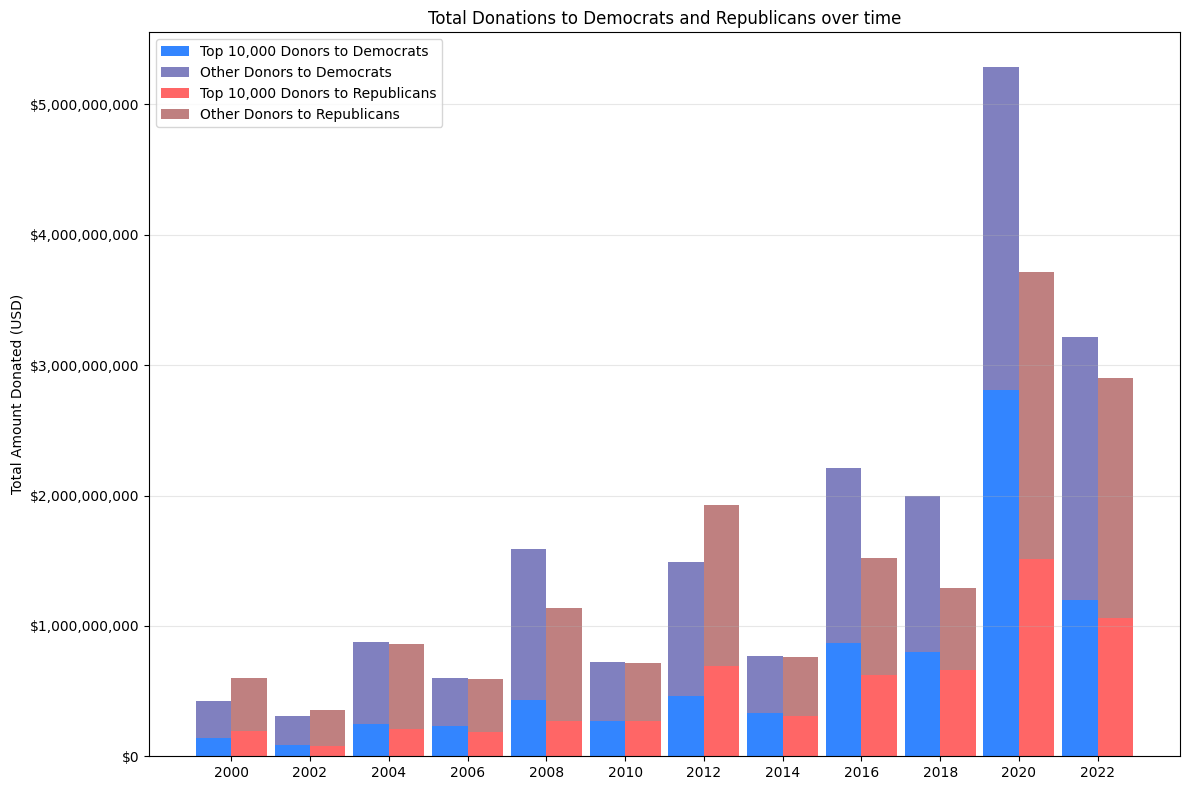

In [15]:
cycle_donations_pivot = cycle_donations.pivot_table(index='cycle', columns='type', values=['D', 'R'])
cycles = sorted(cycle_donations['cycle'].unique())

colors = {
    'Top 10,000 Donors': {'D': '#3385ff', 'R': '#ff6666'},
    'Other Donors': {'D': '#8080BF', 'R': '#BF8080'}
}

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))
x_pos = np.arange(len(cycles))
bar_width = 0.45

# Plot each party
for i, party in enumerate(['D', 'R']):
    bottom = np.zeros(len(cycles))
    
    for type_val in ['Top 10,000 Donors', 'Other Donors']:
        values = cycle_donations_pivot[(party, type_val)].reindex(cycles, fill_value=0).values
        ax.bar(x_pos + i * bar_width, values, bar_width, 
               bottom=bottom, color=colors[type_val][party],
               label=f'{party} - {type_val}')
        bottom += values

# Customize plot
ax.set_ylabel('Total Amount Donated (USD)')
ax.set_title('Total Donations to Democrats and Republicans over time')
ax.set_xticks(x_pos + bar_width/2)
ax.set_xticklabels(cycles)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax.legend(['Top 10,000 Donors to Democrats', 'Other Donors to Democrats', 'Top 10,000 Donors to Republicans', 'Other Donors to Republicans'], loc='upper left', fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
cycle_percentages2 = cycle_donations.copy()

for idx, row in cycle_donations.iterrows():
    cycle = row['cycle']
    party = 'D'
    total_d = cycle_donations[(cycle_donations['cycle'] == cycle)]['D'].sum()
    total_r = cycle_donations[(cycle_donations['cycle'] == cycle)]['R'].sum()
    
    # Calculate percentage share
    cycle_percentages2.at[idx, 'D'] = (row['D'] / total_d * 100) if total_d > 0 else 0
    cycle_percentages2.at[idx, 'R'] = (row['R'] / total_r * 100) if total_r > 0 else 0

cycle_percentages2

party  cycle               type          3          D            I          L  \
0       2000       Other Donors  7330584.0  66.709517     723231.0  1329413.0   
1       2000  Top 10,000 Donors  1695661.0  33.290483     138778.0   248347.0   
2       2002       Other Donors   961776.0  72.215496     301776.0   171647.0   
3       2002  Top 10,000 Donors   126200.0  27.784504     188492.0    35309.0   
4       2004       Other Donors  4782276.0  71.452382     396669.0   749787.0   
5       2004  Top 10,000 Donors   788181.0  28.547618    1227235.0    68035.0   
6       2006       Other Donors   702922.0  61.631605   12897291.0   512038.0   
7       2006  Top 10,000 Donors   172872.0  38.368395    5936209.0    35664.0   
8       2008       Other Donors  4030010.0  73.025724    2408843.0   911631.0   
9       2008  Top 10,000 Donors   613572.0  26.974276     290671.0   174253.0   
10      2010       Other Donors  1297510.0  62.373964   13561346.0   204579.0   
11      2010  Top 10,000 Donors   870012.0  37.626036    2187176.0   261978.0   
12      2012       Other Donors   718786.0  69.237282    4617906.0  1335568.0   
13      2012  Top 10,000 Donors    99368.0  30.762718    8536677.0    38050.0   
14      2014       Other Donors   170700.0  56.965118    3353754.0   183326.0   
15      2014  Top 10,000 Donors   447998.0  43.034882    3434463.0    87210.0   
16      2016       Other Donors  4095420.0  60.748232    2131495.0  3654933.0   
17      2016  Top 10,000 Donors   263746.0  39.251768     733947.0   152958.0   
18      2018       Other Donors   750520.0  59.941646    8360356.0   538799.0   
19      2018  Top 10,000 Donors   198281.0  40.058354   10249458.0   191630.0   
20      2020       Other Donors  1337727.0  46.944400  120721151.0  1443805.0   
21      2020  Top 10,000 Donors   104105.0  53.055600    5399952.0   124830.0   
22      2022       Other Donors  3450545.0  62.685664   14549618.0   484716.0   
23      2022  Top 10,000 Donors   962863.0  37.314336    2366434.0   133038.0   

party          R        U  
0      68.177438  16500.0  
1      31.822562      NaN  
2      77.313267      NaN  
3      22.686733      NaN  
4      75.596054      NaN  
5      24.403946    611.0  
6      67.821889    950.0  
7      32.178111    605.0  
8      75.994074      NaN  
9      24.005926     70.0  
10     62.620289   9750.0  
11     37.379711      NaN  
12     64.085621  52333.0  
13     35.914379   5693.0  
14     58.974317  15335.0  
15     41.025683      NaN  
16     58.919169  10308.0  
17     41.080831   2000.0  
18     48.797269      NaN  
19     51.202731      NaN  
20     59.350277  11189.0  
21     40.649723      NaN  
22     63.443356   8214.0  
23     36.556644      NaN

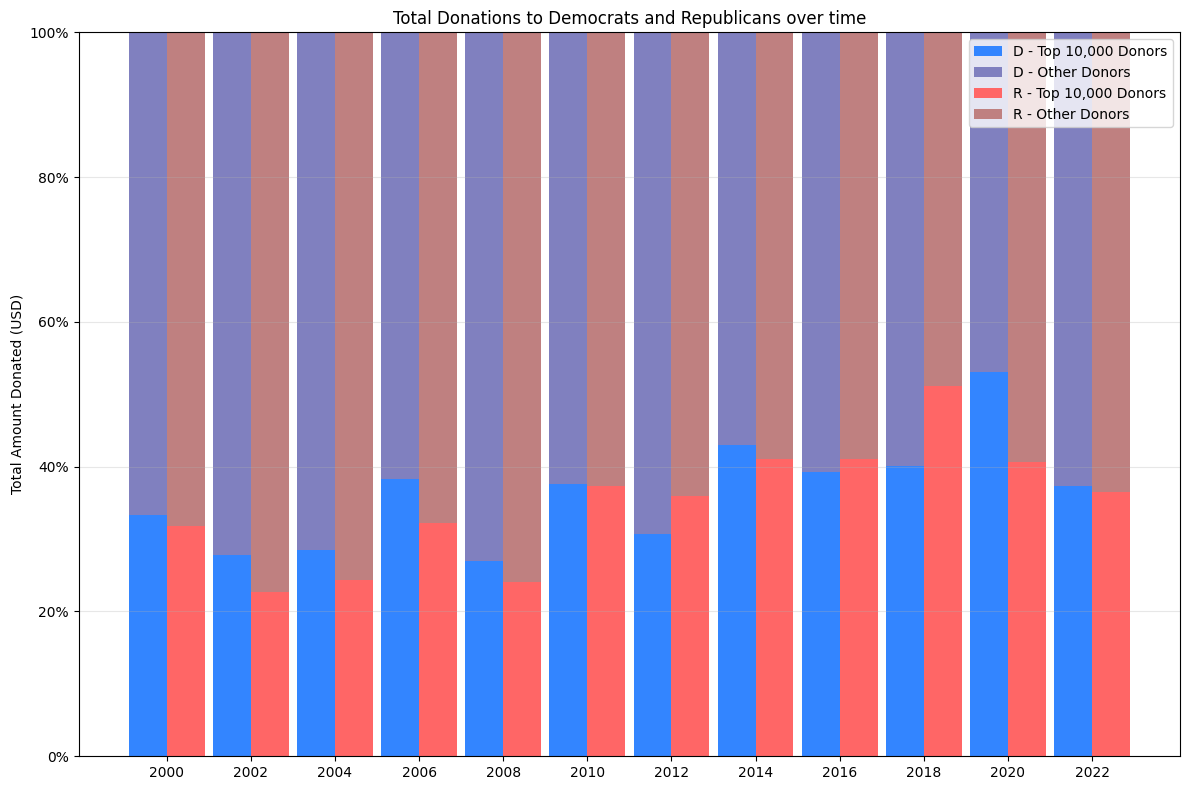

In [17]:
cycle_percentages_pivot = cycle_percentages2.pivot_table(index='cycle', columns='type', values=['D', 'R'])

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))
x_pos = np.arange(len(cycles))
bar_width = 0.45

# Plot each party
for i, party in enumerate(['D', 'R']):
    bottom = np.zeros(len(cycles))
    
    for type_val in ['Top 10,000 Donors', 'Other Donors']:
        values = cycle_percentages_pivot[(party, type_val)].reindex(cycles, fill_value=0).values
        ax.bar(x_pos + i * bar_width, values, bar_width, 
               bottom=bottom, color=colors[type_val][party],
               label=f'{party} - {type_val}')
        bottom += values

# Customize plot
ax.set_ylabel('Total Amount Donated (USD)')
ax.set_title('Total Donations to Democrats and Republicans over time')
ax.set_xticks(x_pos + bar_width/2)
ax.set_xticklabels(cycles)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}%'))
ax.set_ylim(0, 100)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
cycle_pac_donations = (donors.groupby(['cycle', 'recip_is_pac', 'party'])['total_donated']
                  .sum()
                  .unstack())
cycle_pac_percentages = cycle_pac_donations.div(cycle_pac_donations.sum(axis=1), axis=0) * 100
cycle_pac_donations = cycle_pac_donations.reset_index()
cycle_pac_donations

party  cycle  recip_is_pac          3             D            I          L  \
0       2000         False  9026245.0  3.144031e+08     862009.0  1577760.0   
1       2000          True        NaN  1.093303e+08          NaN        NaN   
2       2002         False  1087976.0  2.563341e+08     490268.0   206956.0   
3       2002          True        NaN  5.100673e+07          NaN        NaN   
4       2004         False  5570457.0  5.946197e+08    1623904.0   817822.0   
5       2004          True        NaN  2.792103e+08          NaN        NaN   
6       2006         False   875794.0  4.396883e+08   18833500.0   547702.0   
7       2006          True        NaN  1.640723e+08          NaN        NaN   
8       2008         False  4643582.0  1.092127e+09    2699514.0  1085884.0   
9       2008          True        NaN  4.997300e+08          NaN        NaN   
10      2010         False  2167522.0  5.281543e+08   15748522.0   466557.0   
11      2010          True        NaN  1.984722e+08          NaN        NaN   
12      2012         False   818154.0  8.102432e+08   13154583.0  1373618.0   
13      2012          True        NaN  6.804045e+08          NaN        NaN   
14      2014         False   618698.0  4.778921e+08    6788217.0   270536.0   
15      2014          True        NaN  2.907186e+08          NaN        NaN   
16      2016         False  4359166.0  1.208968e+09    2865442.0  3807891.0   
17      2016          True        NaN  1.005453e+09          NaN        NaN   
18      2018         False   948801.0  1.426379e+09   18609814.0   730429.0   
19      2018          True        NaN  5.737762e+08          NaN        NaN   
20      2020         False  1441832.0  3.721378e+09  126121103.0  1568635.0   
21      2020          True        NaN  1.567312e+09          NaN        NaN   
22      2022         False  4413408.0  1.890627e+09   16916052.0   617754.0   
23      2022          True        NaN  1.324379e+09          NaN        NaN   

party             R        U  
0      4.606819e+08  16500.0  
1      1.382959e+08      NaN  
2      2.449812e+08      NaN  
3      1.111136e+08      NaN  
4      5.618179e+08    611.0  
5      2.980040e+08      NaN  
6      3.930338e+08   1555.0  
7      1.970053e+08      NaN  
8      7.410971e+08     70.0  
9      3.950715e+08      NaN  
10     5.762908e+08   9750.0  
11     1.381308e+08      NaN  
12     1.070437e+09  58026.0  
13     8.575013e+08      NaN  
14     5.448615e+08  15335.0  
15     2.172285e+08      NaN  
16     8.856108e+08  12308.0  
17     6.326826e+08      NaN  
18     7.227539e+08      NaN  
19     5.676364e+08      NaN  
20     1.211423e+09  11189.0  
21     2.505756e+09      NaN  
22     1.087747e+09   8214.0  
23     1.810349e+09      NaN

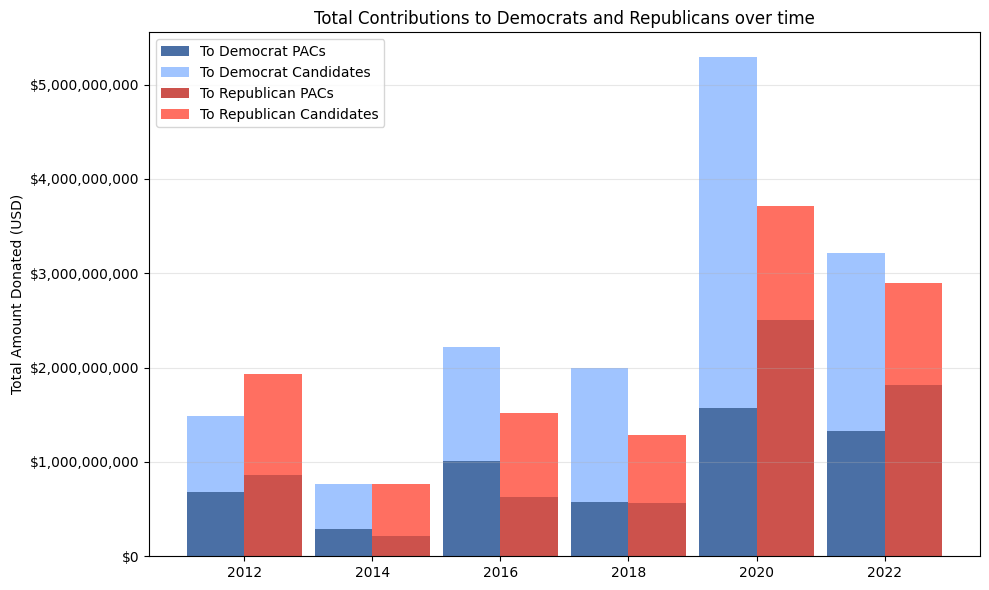

In [19]:
cycle_pac_donations_pivot = cycle_pac_donations.fillna(0).pivot_table(index='cycle', columns='recip_is_pac', values=['D', 'R'])
cycle_pac_donations_pivot = cycle_pac_donations_pivot[cycle_pac_donations_pivot.index >= 2012]
cycles = sorted(cycle_pac_donations['cycle'].unique())
cycles_pac = cycles[cycles.index(2012):]

colors = {
    True: {'D': '#4A6FA5', 'R': '#cc524c'},
    False: {'D': '#A0C4FF', 'R': '#FF6F61'}
}

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(cycles_pac))
bar_width = 0.45

# Plot each party
for i, party in enumerate(['D', 'R']):
    bottom = np.zeros(len(cycles_pac))
    
    for type_val in [True, False]:
        values = cycle_pac_donations_pivot[(party, type_val)].reindex(cycles_pac, fill_value=0).values
        ax.bar(x_pos + i * bar_width, values, bar_width, 
               bottom=bottom, color=colors[type_val][party],
               label=f'{party} - {type_val}')
        bottom += values

# Customize plot
ax.set_ylabel('Total Amount Donated (USD)')
ax.set_title('Total Contributions to Democrats and Republicans over time')
ax.set_xticks(x_pos + bar_width/2)
ax.set_xticklabels(cycles_pac)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax.legend(['To Democrat PACs', 'To Democrat Candidates', 'To Republican PACs', 'To Republican Candidates'], loc='upper left', fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
donors[(donors["recip_is_pac"] == True) & (~donors["party"].isin(["D", "R"]))]["name_y"].value_counts()[200:220]

name_y
Carpenters & Joiners Union                     6588
Congressional Progressive Caucus PAC           6578
Democratic Party of New Mexico                 6577
Wine & Spirits Wholesalers of America          6561
Eli Lilly & Co                                 6558
Republican Party of South Carolina             6515
Indiana Republican State Cmte                  6506
VIGOP                                          6423
Associated General Contractors                 6415
Black America's PAC                            6339
Union Pacific Corp                             6330
Ted Cruz Victory Cmte                          6323
Human Rights Campaign                          6118
Safari Club International                      6107
Congressional Leadership Fund                  6085
Altria Group                                   6044
American Postal Workers Union                  6042
New York State Democratic Cmte                 6016
American Federation of Government Employees    5979
Ameri

In [21]:
# top_donors.drop_duplicates(subset=['contrib_id'], inplace=True)
# top_donors.sort_values(by='total_donated', ascending=False, inplace=True)
# top_donors.to_csv("./output/top_donors_recip_unique.csv", index=False)

In [22]:
donors_avg = donors.groupby(['cycle', 'indian', 'party']).agg(mean=('total_donated', 'mean'), median=('total_donated', 'median')).reset_index()
donors_avg = donors_avg.pivot(index='cycle', columns=['indian', 'party'], values=['mean', 'median']).fillna(0).reset_index()
donors_avg.columns = ['cycle',
                      'mean_other_3', 'mean_other_d', 'mean_other_i', 'mean_other_l', 'mean_other_r','mean_other_u', 
                      'mean_indian_3', 'mean_indian_d', 'mean_indian_i', 'mean_indian_l', 'mean_indian_r','mean_indian_u', 
                      'median_other_3', 'median_other_d', 'median_other_i', 'median_other_l', 'median_other_r','median_other_u', 
                      'median_indian_3', 'median_indian_d', 'median_indian_i', 'median_indian_l', 'median_indian_r','median_indian_u']
donors_avg

cycle  mean_other_3  mean_other_d  mean_other_i  mean_other_l  \
0    2000    756.295176   1063.026158    699.722313    731.006993   
1    2002    976.414722    921.936069    716.864706    678.303030   
2    2004    969.166870   1143.421335   1553.496651    816.603206   
3    2006    879.131181   1293.724228   1534.385629   1171.771552   
4    2008   1055.278655   1481.046240    897.570997    854.561655   
5    2010   1238.611271   1420.822872   1505.769980   2111.117647   
6    2012    643.573482   1512.688032   2375.060239    878.314672   
7    2014   3637.929412   1762.160672   1974.321082   1213.165919   
8    2016    651.402337   1289.511737   1049.819739    552.384503   
9    2018   1416.781109   1389.556764    980.652692   1440.096647   
10   2020    932.652542   1666.315579    548.279354    620.545671   
11   2022   1595.817649   1429.627148    642.854904   1724.910364   

    mean_other_r  mean_other_u  mean_indian_3  mean_indian_d  mean_indian_i  \
0    1062.392730    515.625000     556.900000     975.697659     687.500000   
1     897.574619      0.000000     250.000000     789.356864     700.000000   
2    1272.719188    611.000000     624.137931    1151.700292     500.000000   
3    1321.968257    388.750000     653.571429    1240.469012    1305.261538   
4    1394.061858     70.000000    1146.629630    1473.429415     916.071429   
5    1362.624565   1950.000000    2262.833333    1372.449599    1571.612360   
6    1966.155446   1031.714286     652.631579    1608.626720     701.388889   
7    1713.321382   1330.454545     250.000000    1730.002103    1501.040816   
8    1172.563231   2051.333333     721.247312    1662.948991    1085.488372   
9    1584.278542      0.000000     634.666667    1528.120873   62547.628205   
10   1390.381567    799.214286     795.928571    1437.252866     672.021764   
11   1147.446539   1642.800000     986.250000    1919.660765     674.509506   

    ...  median_other_i  median_other_l  median_other_r  median_other_u  \
0   ...           500.0           500.0           500.0           475.0   
1   ...           300.0           400.0           500.0             0.0   
2   ...           300.0           500.0           500.0           611.0   
3   ...          1000.0           500.0           500.0           375.0   
4   ...           300.0           500.0           500.0            70.0   
5   ...           750.0           500.0           500.0          1000.0   
6   ...           500.0           500.0           500.0           500.0   
7   ...           500.0           500.0           650.0           500.0   
8   ...           350.0           250.0           250.0          1005.0   
9   ...           250.0           500.0           400.0             0.0   
10  ...           211.0           250.0           300.0           550.0   
11  ...           237.0           500.0           300.0          1911.0   

    median_indian_3  median_indian_d  median_indian_i  median_indian_l  \
0             500.0            500.0            750.0            500.0   
1             250.0            500.0            750.0            500.0   
2             500.0            500.0            500.0            401.0   
3             500.0            500.0           1000.0            500.0   
4             600.0            725.0            300.0           1000.0   
5            1750.0            500.0           1000.0              0.0   
6             250.0            500.0            500.0            500.0   
7             250.0            700.0           1000.0              0.0   
8             500.0            500.0            500.0            250.0   
9             285.5            550.0            380.0            150.0   
10            500.0            500.0            250.0            250.0   
11            500.0            600.0            250.0            375.0   

    median_indian_r  median_indian_u  
0             500.0              0.0  
1             500.0              0.0  
2             500.0   

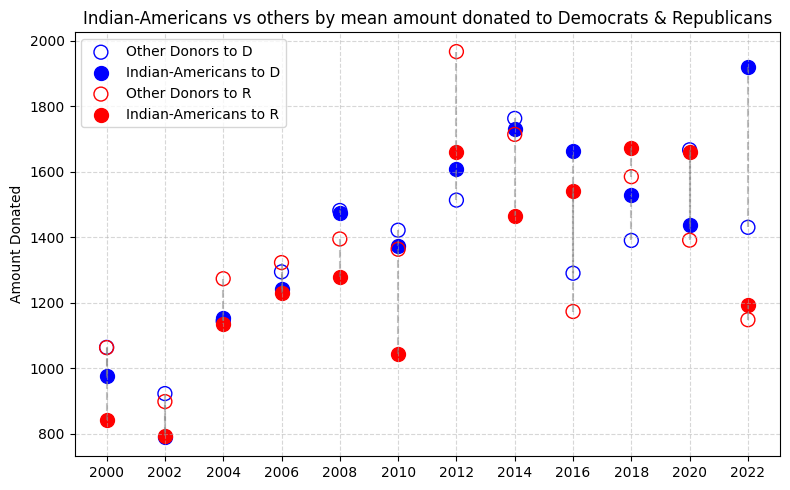

In [23]:
plt.figure(figsize=(8, 5))

cycles = pd.Series(donors_avg["cycle"]).apply(lambda x: str(x)[:4])
for cat, g1, g2 in zip(cycles, donors_avg["mean_other_d"], donors_avg["mean_indian_d"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)
for cat, g1, g2 in zip(cycles, donors_avg["mean_other_r"], donors_avg["mean_indian_r"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(cycles, donors_avg["mean_other_d"], facecolors='none', edgecolors='blue', color='blue', label='Other Donors to D', s=100)
plt.scatter(cycles, donors_avg["mean_indian_d"], color='blue', label='Indian-Americans to D', s=100)
plt.scatter(cycles, donors_avg["mean_other_r"], facecolors='none', edgecolors='red', label='Other Donors to R', s=100)
plt.scatter(cycles, donors_avg["mean_indian_r"], color='red', label='Indian-Americans to R', s=100)

plt.title(f"Indian-Americans vs others by mean amount donated to Democrats & Republicans")
plt.ylabel("Amount Donated")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

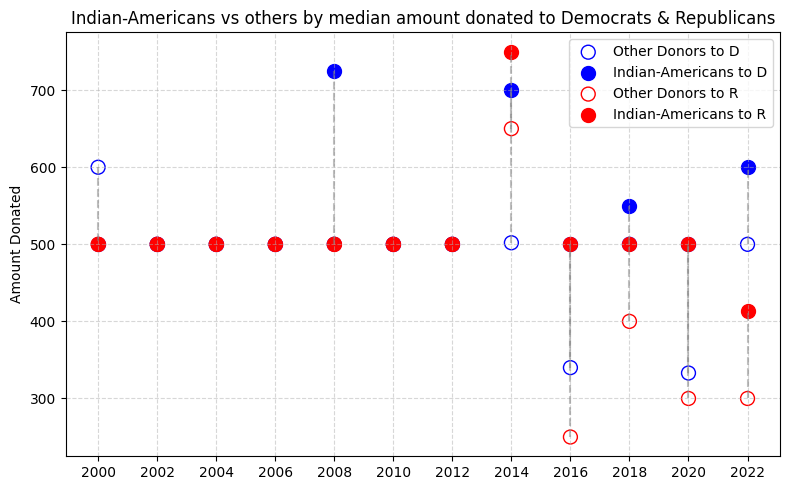

In [24]:
plt.figure(figsize=(8, 5))

cycles = pd.Series(donors_avg["cycle"]).apply(lambda x: str(x)[:4])
for cat, g1, g2 in zip(cycles, donors_avg["median_other_d"], donors_avg["median_indian_d"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)
for cat, g1, g2 in zip(cycles, donors_avg["median_other_r"], donors_avg["median_indian_r"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(cycles, donors_avg["median_other_d"], facecolors='none', edgecolors='blue', color='blue', label='Other Donors to D', s=100)
plt.scatter(cycles, donors_avg["median_indian_d"], color='blue', label='Indian-Americans to D', s=100)
plt.scatter(cycles, donors_avg["median_other_r"], facecolors='none', edgecolors='red', label='Other Donors to R', s=100)
plt.scatter(cycles, donors_avg["median_indian_r"], color='red', label='Indian-Americans to R', s=100)

plt.title(f"Indian-Americans vs others by median amount donated to Democrats & Republicans")
plt.ylabel("Amount Donated")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [25]:
sectors_avg = donors[(donors["cycle"] == 2000 + year) & (~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"]))].groupby(['sector', 'indian', 'party']).agg(mean=('total_donated', 'mean'), median=('total_donated', 'median')).reset_index()
sectors_avg = sectors_avg.pivot(index='sector', columns=['indian', 'party'], values=['mean', 'median']).fillna(0).reset_index()
sectors_avg.columns = ['sector',
                      'mean_other_3', 'mean_other_d', 'mean_other_i', 'mean_other_l', 'mean_other_r',
                      'mean_indian_d', 'mean_indian_i', 'mean_indian_r', 'mean_other_u', 'mean_indian_3','mean_indian_l', 
                      'median_other_3', 'median_other_d', 'median_other_i', 'median_other_l', 'median_other_r', 
                      'median_indian_d', 'median_indian_i', 'median_indian_r', 'median_other_u', 'median_indian_3','median_indian_l']
sectors_avg

sector  mean_other_3  mean_other_d  mean_other_i  mean_other_l  \
0     Agribusiness    672.428571   1210.266867    424.022171    314.333333   
1     Construction    806.900000    925.678595    443.004935   1310.462687   
2          Defense      0.000000    776.811991    537.358442    266.363636   
3        Education    381.605263    632.582678    412.036050    393.096774   
4           Energy    209.142857   1528.998813    512.912744    405.657143   
5          Finance   1129.673913   2619.512023    545.251376   1010.474419   
6           Health    756.530612    854.756749    479.232169    543.545082   
7            Labor    234.428571    573.527314    405.507910    263.833333   
8              Law   1291.521368   1421.890099    630.258721    582.725000   
9    Manufacturing   1046.142857   1367.870282    396.203117   1442.163265   
10           Media    566.000000   1349.180204    468.220254    569.614035   
11            Tech    484.490196   1739.992204    602.972294    527.926087   
12  Transportation    476.160000   1087.558893    391.927886    402.312500   

    mean_other_r  mean_indian_d  mean_indian_i  mean_indian_r  mean_other_u  \
0    1716.672983    1953.905263     274.750000    4659.159091           0.0   
1    1496.426955    1367.630021     574.854167    1771.388571         273.0   
2    1652.367332    2102.953271     329.153846     471.391304           0.0   
3     640.129821     645.512792     683.714286     871.279070           0.0   
4    3075.966183    1259.284746     288.875000    1189.212329        1600.0   
5    3507.397785    4108.073895     515.914474    3254.774254           0.0   
6    1264.697562    1325.680209     640.825225    2423.238606           0.0   
7     590.079286     706.772727     365.250000    1210.750000           0.0   
8    1620.831510    1316.253986     707.717391    1259.041667           0.0   
9    3526.473749    3128.579882     895.071429    2282.648000           0.0   
10   1433.534229    1177.378685     487.709677    1021.266667         125.0   
11   1853.563941    1299.492211     664.945355    1592.459507        1870.5   
12   1538.212343    1372.974194     567.792453    1003.056931           0.0   

    ...  median_other_d  median_other_i  median_other_l  median_other_r  \
0   ...           329.5           188.5           250.0           500.0   
1   ...           250.0           190.0           250.0           375.0   
2   ...           280.0           217.0           225.0           344.0   
3   ...           245.0           185.0           250.0           250.0   
4   ...           350.0           200.0           250.0           500.0   
5   ...           500.0           200.0           300.0           500.0   
6   ...           250.0           195.0           250.0           300.0   
7   ...           250.0           192.0           175.0           250.0   
8   ...           500.0           254.0           250.5           500.0   
9   ...           277.5           189.0           300.0           500.0   
10  ...           300.0           189.0           250.0           300.0   
11  ...           300.0           226.0           250.0           300.0   
12  ...           250.0           178.0           202.0           300.0   

    median_indian_d  median_indian_i  median_indian_r  median_other_u  \
0             500.0            116.5            585.0             0.0   
1             500.0            248.0            500.0           273.0   
2             389.0            100.0            250.0             0.0   
3             270.0            223.5            256.0             0.0   
4             500.0            200.0            500.0          1600.0   
5            1000.0            191.0            554.0             0.0   
6             500.0            239.0            500.0             0.0   
7             225.0            197.0            785.0             0.0   
8             500.0            334.0            500.0             0.0   
9             660.0            

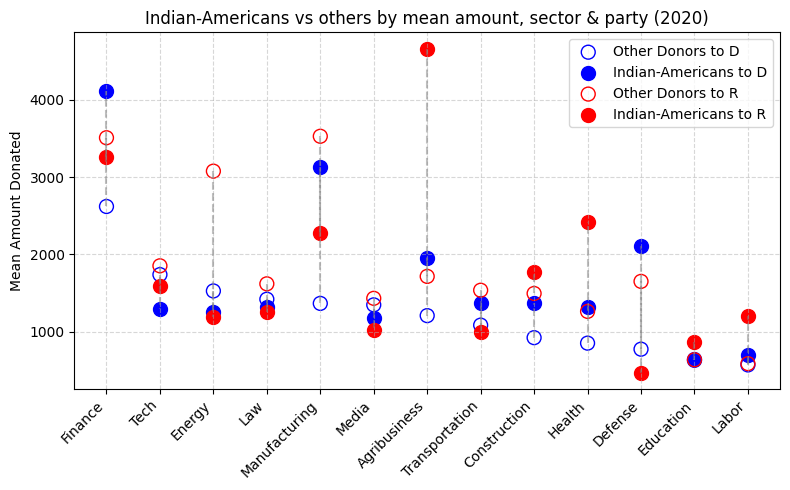

In [26]:
plt.figure(figsize=(8, 5))

sectors_avg = sectors_avg.sort_values(by='mean_other_d', ascending=False)
sectors = sectors_avg["sector"].tolist()

for cat, g1, g2 in zip(sectors, sectors_avg["mean_other_d"], sectors_avg["mean_indian_d"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)
for cat, g1, g2 in zip(sectors, sectors_avg["mean_other_r"], sectors_avg["mean_indian_r"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, sectors_avg["mean_other_d"], facecolors='none', edgecolors='blue', label='Other Donors to D', s=100)
plt.scatter(sectors, sectors_avg["mean_indian_d"], color='blue', label='Indian-Americans to D', s=100)
plt.scatter(sectors, sectors_avg["mean_other_r"], facecolors='none', edgecolors='red', label='Other Donors to R', s=100)
plt.scatter(sectors, sectors_avg["mean_indian_r"], color='red', label='Indian-Americans to R', s=100)

plt.title(f"Indian-Americans vs others by mean amount, sector & party (20{year})")
plt.ylabel("Mean Amount Donated")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

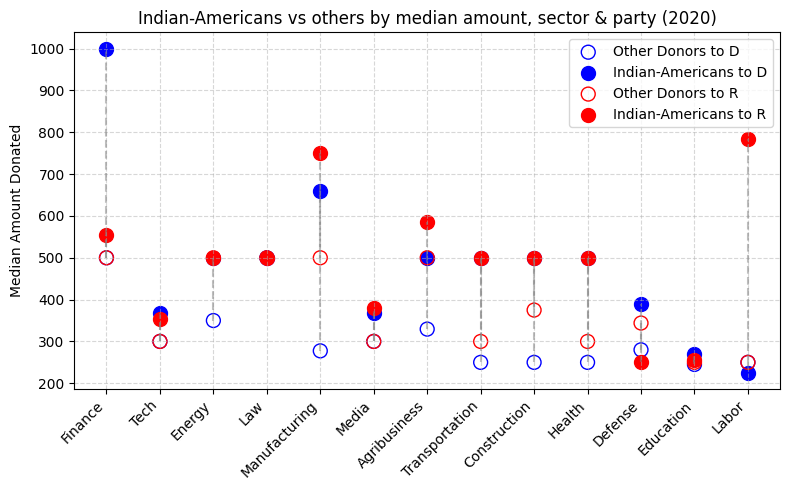

In [27]:
plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, sectors_avg["median_other_d"], sectors_avg["median_indian_d"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)
for cat, g1, g2 in zip(sectors, sectors_avg["median_other_r"], sectors_avg["median_indian_r"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, sectors_avg["median_other_d"], facecolors='none', edgecolors='blue', label='Other Donors to D', s=100)
plt.scatter(sectors, sectors_avg["median_indian_d"], color='blue', label='Indian-Americans to D', s=100)
plt.scatter(sectors, sectors_avg["median_other_r"], facecolors='none', edgecolors='red', label='Other Donors to R', s=100)
plt.scatter(sectors, sectors_avg["median_indian_r"], color='red', label='Indian-Americans to R', s=100)

plt.title(f"Indian-Americans vs others by median amount, sector & party (20{year})")
plt.ylabel("Median Amount Donated")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [28]:
# statistical tests

model = ols('total_donated ~ C(indian) + C(sector) + cycle', data=donors).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                 sum_sq          df          F        PR(>F)
C(indian)  1.130532e+10         1.0   0.178448  6.727104e-01
C(sector)  1.136621e+13        15.0  11.960618  3.128437e-30
cycle      3.901509e+11         1.0   6.158311  1.307961e-02
Residual   1.569635e+18  24775800.0        NaN           NaN


In [29]:
tukey = pairwise_tukeyhsd(endog=donors[(donors["total_donated"].notnull())]['total_donated'],
                         groups=donors[(donors["total_donated"].notnull())]['indian'],
                         alpha=0.05)
print(tukey.summary())

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower    upper   reject
--------------------------------------------------------
 False   True -103.8153 0.7834 -843.8623 636.2318  False
--------------------------------------------------------


In [30]:
# donors["dollar_lean"] = donors.apply(lambda x: x["total_donated"] * -1 if x["party"] == "R" else x["total_donated"] * 0 if x["party"] not in ["D", "R"] else x["total_donated"], axis=1)
donors['dollar_lean'] = np.select([donors['party'] == 'R', ~donors['party'].isin(['D', 'R'])], [donors['total_donated'] * -1, 0], default=donors['total_donated'])

donors_lean = donors[~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])].groupby(['cycle', 'indian', 'sector']).agg(lean=('dem_ratio', 'mean'), dollar_lean=('dollar_lean', 'sum'), total=('total_donated', 'sum')).reset_index()
donors_lean["dollar_lean"] = donors_lean["dollar_lean"] / donors_lean["total"]

donors_lean = donors_lean.pivot(index=['cycle', 'sector'], columns='indian', values=['lean', 'dollar_lean']).fillna(0).reset_index()
donors_lean.columns = ["cycle", 'sector', 'lean_other', 'lean_indian', 'dollar_lean_other', 'dollar_lean_indian']
donors_lean

cycle          sector  lean_other  lean_indian  dollar_lean_other  \
0     2000    Agribusiness   -0.516002    -0.365492          -0.307302   
1     2000    Construction   -0.411764     0.089874          -0.267908   
2     2000         Defense   -0.319229     0.131313          -0.229048   
3     2000       Education    0.239441     0.555556           0.178984   
4     2000          Energy   -0.534815     0.055507          -0.311897   
..     ...             ...         ...          ...                ...   
151   2022             Law    0.399037     0.624188           0.288186   
152   2022   Manufacturing   -0.336261     0.552380          -0.150011   
153   2022           Media    0.645828     0.798052           0.484670   
154   2022            Tech    0.460030     0.693451           0.260682   
155   2022  Transportation   -0.400671     0.143179          -0.197726   

     dollar_lean_indian  
0             -0.341621  
1              0.137898  
2              0.228475  
3              0.535714  
4              0.137299  
..                  ...  
151            0.471985  
152            0.511199  
153            0.598534  
154            0.466018  
155            0.130046  

[156 rows x 6 columns]

In [31]:
donors_pac_lean = donors[~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])].groupby(['cycle', 'indian', 'sector', 'level']).agg(lean=('dem_ratio', 'mean'), dollar_lean=('dollar_lean', 'sum'), total=('total_donated', 'sum')).reset_index()
donors_pac_lean["dollar_lean"] = donors_pac_lean["dollar_lean"] / donors_pac_lean["total"]

donors_pac_lean = donors_pac_lean.pivot(index=['cycle', 'sector', 'level'], columns='indian', values=['lean', 'dollar_lean']).fillna(0).reset_index()
donors_pac_lean.columns = ["cycle", 'sector', 'level', 'lean_other', 'lean_indian', 'dollar_lean_other', 'dollar_lean_indian']
donors_pac_lean

cycle          sector      level  lean_other  lean_indian  \
0     2000    Agribusiness      House   -0.414964    -0.185984   
1     2000    Agribusiness        PAC   -0.682744    -0.560440   
2     2000    Agribusiness  President   -0.647767    -1.000000   
3     2000    Construction      House   -0.330905     0.118478   
4     2000    Construction        PAC   -0.592667     0.060740   
..     ...             ...        ...         ...          ...   
568   2022            Tech    Unknown    0.083333     0.000000   
569   2022  Transportation      House   -0.195943     0.274980   
570   2022  Transportation        PAC   -0.630195    -0.168249   
571   2022  Transportation  President    0.694972     0.777778   
572   2022  Transportation    Unknown    1.000000     0.000000   

     dollar_lean_other  dollar_lean_indian  
0            -0.391191           -0.165761  
1            -0.182507           -0.249623  
2            -0.677048           -1.000000  
3            -0.308139            0.101233  
4            -0.164680            0.245357  
..                 ...                 ...  
568           0.000000            0.000000  
569          -0.300671            0.434274  
570          -0.166606           -0.088055  
571          -0.078221            0.320106  
572           0.000000            0.000000  

[573 rows x 7 columns]

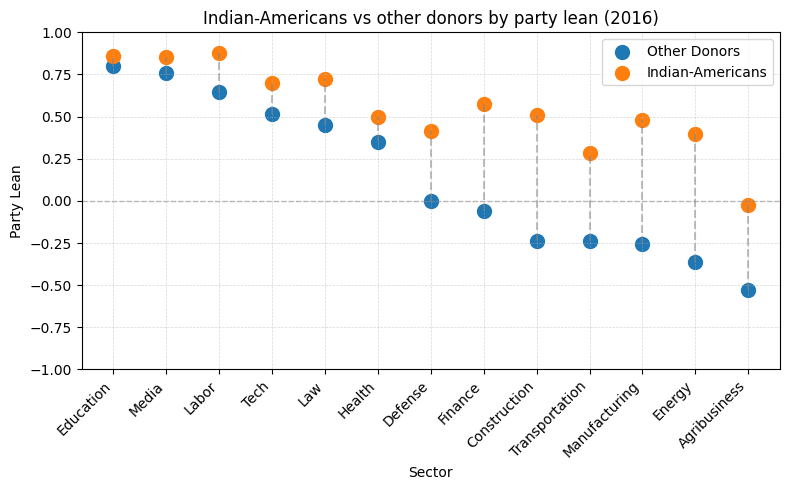

In [32]:
donors_lean_year = donors_lean[donors_lean["cycle"] == 2000 + 16].sort_values(by="lean_other", ascending=False)
sectors = donors_lean_year["sector"]

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, donors_lean_year["lean_other"], donors_lean_year["lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, donors_lean_year["lean_other"], cmap="coolwarm_r", label='Other Donors', s=100)
plt.scatter(sectors, donors_lean_year["lean_indian"], cmap="coolwarm_r", label='Indian-Americans', s=100)

plt.title(f"Indian-Americans vs other donors by party lean (20{16})")
plt.xlabel("Sector")
plt.ylabel("Party Lean")
plt.xticks(rotation=45, ha='right')
plt.ylim(-1, 1)

plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0, color='grey', alpha=0.5, linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

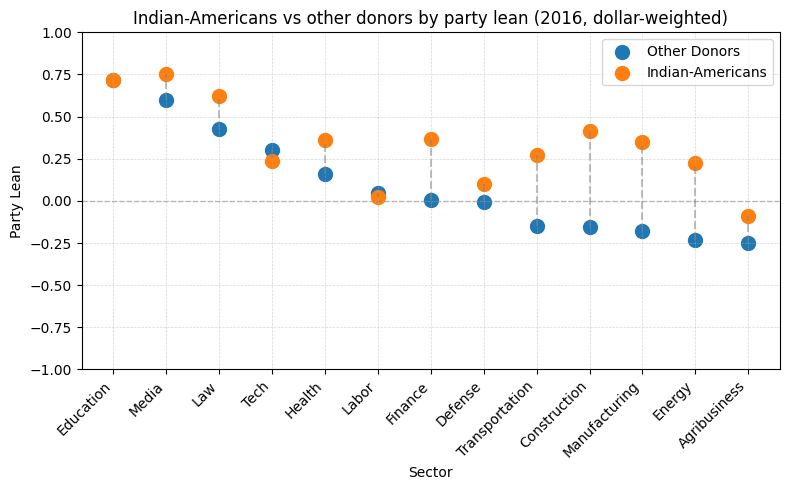

In [33]:
donors_lean_year = donors_lean[donors_lean["cycle"] == 2000 + 16].sort_values(by="dollar_lean_other", ascending=False)
sectors = donors_lean_year["sector"]

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, donors_lean_year["dollar_lean_other"], donors_lean_year["dollar_lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, donors_lean_year["dollar_lean_other"], cmap="coolwarm_r", label='Other Donors', s=100)
plt.scatter(sectors, donors_lean_year["dollar_lean_indian"], cmap="coolwarm_r", label='Indian-Americans', s=100)

plt.title(f"Indian-Americans vs other donors by party lean (20{16}, dollar-weighted)")
plt.xlabel("Sector")
plt.ylabel("Party Lean")
plt.xticks(rotation=45, ha='right')
plt.ylim(-1, 1)

plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0, color='grey', alpha=0.5, linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

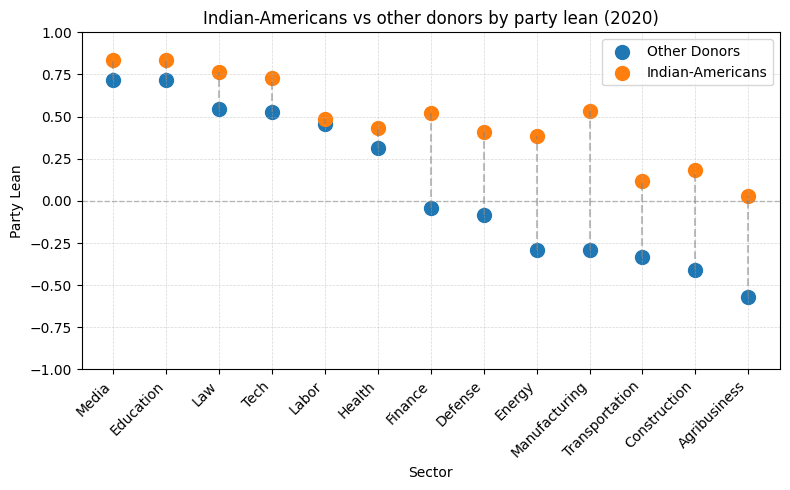

In [34]:
donors_lean_year = donors_lean[donors_lean["cycle"] == 2000 + year].sort_values(by="lean_other", ascending=False)
sectors = donors_lean_year["sector"]

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, donors_lean_year["lean_other"], donors_lean_year["lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, donors_lean_year["lean_other"], cmap="coolwarm_r", label='Other Donors', s=100)
plt.scatter(sectors, donors_lean_year["lean_indian"], cmap="coolwarm_r", label='Indian-Americans', s=100)

plt.title(f"Indian-Americans vs other donors by party lean (20{year})")
plt.xlabel("Sector")
plt.ylabel("Party Lean")
plt.xticks(rotation=45, ha='right')
plt.ylim(-1, 1)

plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0, color='grey', alpha=0.5, linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

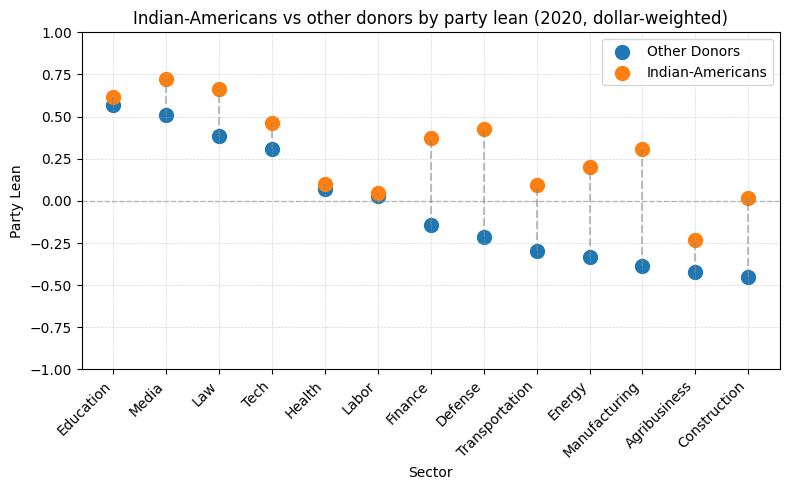

In [35]:
donors_lean_year = donors_lean[donors_lean["cycle"] == 2000 + year].sort_values(by="dollar_lean_other", ascending=False)
sectors = donors_lean_year["sector"]

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, donors_lean_year["dollar_lean_other"], donors_lean_year["dollar_lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, donors_lean_year["dollar_lean_other"], cmap="coolwarm_r", label='Other Donors', s=100)
plt.scatter(sectors, donors_lean_year["dollar_lean_indian"], cmap="coolwarm_r", label='Indian-Americans', s=100)

plt.title(f"Indian-Americans vs other donors by party lean (20{year}, dollar-weighted)")
plt.xlabel("Sector")
plt.ylabel("Party Lean")
plt.xticks(rotation=45, ha='right')
plt.ylim(-1, 1)

plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0, color='grey', alpha=0.5, linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

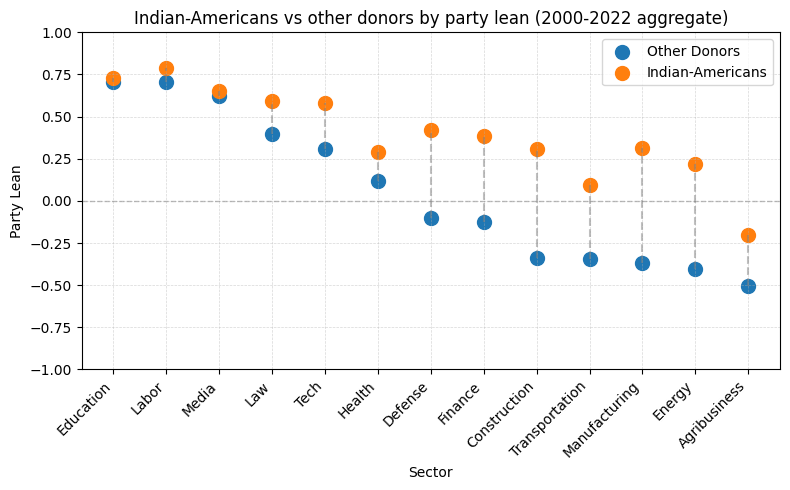

In [36]:
donors_lean_year = donors_lean.groupby(['sector']).agg(lean_other=('lean_other', 'mean'), lean_indian=('lean_indian', 'mean')).reset_index().sort_values(by="lean_other", ascending=False)
sectors = donors_lean_year["sector"]

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, donors_lean_year["lean_other"], donors_lean_year["lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, donors_lean_year["lean_other"], cmap="coolwarm_r", label='Other Donors', s=100)
plt.scatter(sectors, donors_lean_year["lean_indian"], cmap="coolwarm_r", label='Indian-Americans', s=100)

plt.title(f"Indian-Americans vs other donors by party lean (2000-2022 aggregate)")
plt.xlabel("Sector")
plt.ylabel("Party Lean")
plt.xticks(rotation=45, ha='right')
plt.ylim(-1, 1)

plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0, color='grey', alpha=0.5, linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

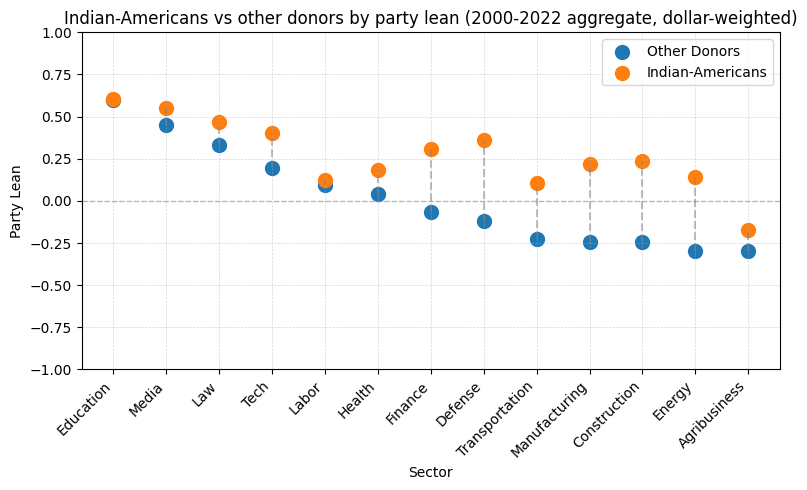

In [37]:
donors_lean_year = donors_lean.groupby(['sector']).agg(lean_other=('lean_other', 'mean'), lean_indian=('lean_indian', 'mean'), dollar_lean_other=('dollar_lean_other', 'mean'), dollar_lean_indian=('dollar_lean_indian', 'mean')).reset_index().sort_values(by="dollar_lean_other", ascending=False)
sectors = donors_lean_year["sector"]

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, donors_lean_year["dollar_lean_other"], donors_lean_year["dollar_lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, donors_lean_year["dollar_lean_other"], cmap="coolwarm_r", label='Other Donors', s=100)
plt.scatter(sectors, donors_lean_year["dollar_lean_indian"], cmap="coolwarm_r", label='Indian-Americans', s=100)

plt.title(f"Indian-Americans vs other donors by party lean (2000-2022 aggregate, dollar-weighted)")
plt.xlabel("Sector")
plt.ylabel("Party Lean")
plt.xticks(rotation=45, ha='right')
plt.ylim(-1, 1)

plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0, color='grey', alpha=0.5, linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

In [38]:
# statistical tests

model = ols('dem_ratio ~ C(indian) + C(sector) + cycle', data=donors).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                 sum_sq          df              F  PR(>F)
C(indian)  3.070936e+04         1.0   35261.931393     0.0
C(sector)  1.603928e+06        15.0  122780.409608     0.0
cycle      3.986956e+04         1.0   45780.111390     0.0
Residual   1.802183e+07  20693517.0            NaN     NaN


In [39]:
tukey = pairwise_tukeyhsd(endog=donors[(donors["dem_ratio"].notnull())]['dem_ratio'],
                         groups=donors[(donors["dem_ratio"].notnull())]['indian'],
                         alpha=0.05)
print(tukey.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
 False   True   0.3774   0.0 0.3738 0.3811   True
-------------------------------------------------


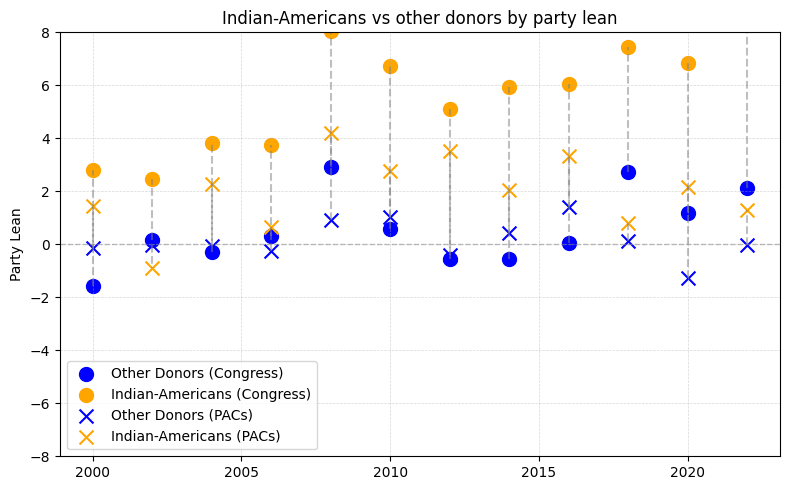

In [40]:
# this needs to be fixed by aggregating cycle averages correctly (currently sums party leans of each sector instead of calculating dollar weighted lean)
# also, the "regular" party lean needs to be fixed because it's at the level of donations, not donors

donors_lean_yearly = donors_pac_lean.groupby(["cycle", "level"]).sum().sort_values(by="cycle", ascending=True).reset_index()
cycles = donors_lean_yearly[donors_lean_yearly["level"] == "President"]["cycle"]

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(cycles, donors_lean_yearly[donors_lean_yearly["level"] == "House"]["dollar_lean_other"], donors_lean_yearly[donors_lean_yearly["level"] == "House"]["dollar_lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)
for cat, g1, g2 in zip(cycles, donors_lean_yearly[donors_lean_yearly["level"] == "PAC"]["dollar_lean_other"], donors_lean_yearly[donors_lean_yearly["level"] == "PAC"]["dollar_lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(cycles, donors_lean_yearly[donors_lean_yearly["level"] == "House"]["dollar_lean_other"], color="blue", label='Other Donors (Congress)', s=100)
plt.scatter(cycles, donors_lean_yearly[donors_lean_yearly["level"] == "House"]["dollar_lean_indian"], color="orange",  label='Indian-Americans (Congress)', s=100)
plt.scatter(cycles, donors_lean_yearly[donors_lean_yearly["level"] == "PAC"]["dollar_lean_other"], marker="x", color="blue", label='Other Donors (PACs)', s=100)
plt.scatter(cycles, donors_lean_yearly[donors_lean_yearly["level"] == "PAC"]["dollar_lean_indian"], marker="x", color="orange",  label='Indian-Americans (PACs)', s=100)

plt.title(f"Indian-Americans vs other donors by party lean")
plt.ylabel("Party Lean")
plt.ylim(-8, 8)

plt.legend(loc='lower left')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0, color='grey', alpha=0.5, linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

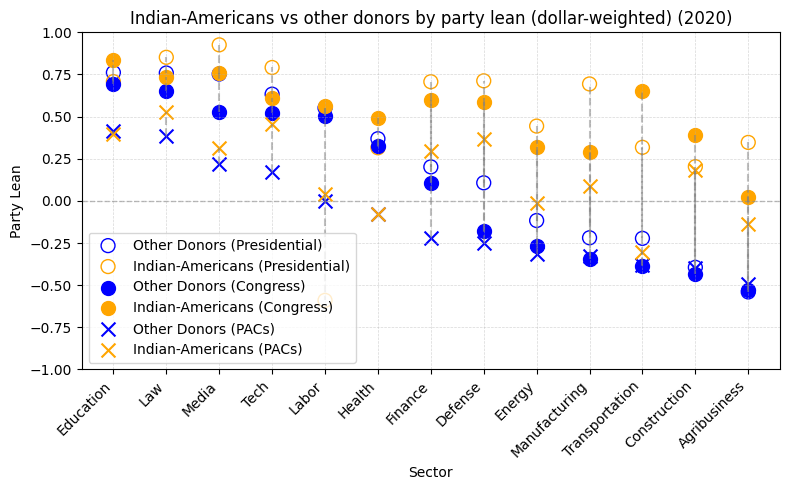

In [41]:
donors_lean_year = donors_pac_lean[donors_pac_lean["cycle"] == 2000 + year].sort_values(by="dollar_lean_other", ascending=False)
sectors = donors_lean_year[donors_lean_year["level"] == "President"]["sector"]

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, donors_lean_year[donors_lean_year["level"] == "President"]["dollar_lean_other"], donors_lean_year[donors_lean_year["level"] == "President"]["dollar_lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)
for cat, g1, g2 in zip(sectors, donors_lean_year[donors_lean_year["level"] == "House"]["dollar_lean_other"], donors_lean_year[donors_lean_year["level"] == "House"]["dollar_lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)
for cat, g1, g2 in zip(sectors, donors_lean_year[donors_lean_year["level"] == "PAC"]["dollar_lean_other"], donors_lean_year[donors_lean_year["level"] == "PAC"]["dollar_lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "President"]["dollar_lean_other"], facecolors='none', edgecolors='blue', label='Other Donors (Presidential)', s=100)
plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "President"]["dollar_lean_indian"], facecolors='none', edgecolors='orange', label='Indian-Americans (Presidential)', s=100)
plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "House"]["dollar_lean_other"], color="blue", label='Other Donors (Congress)', s=100)
plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "House"]["dollar_lean_indian"], color="orange",  label='Indian-Americans (Congress)', s=100)
plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "PAC"]["dollar_lean_other"], marker="x", color="blue", label='Other Donors (PACs)', s=100)
plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "PAC"]["dollar_lean_indian"], marker="x", color="orange",  label='Indian-Americans (PACs)', s=100)

plt.title(f"Indian-Americans vs other donors by party lean (dollar-weighted) (20{year})")
plt.xlabel("Sector")
plt.ylabel("Party Lean")
plt.xticks(rotation=45, ha='right')
plt.ylim(-1, 1)

plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0, color='grey', alpha=0.5, linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

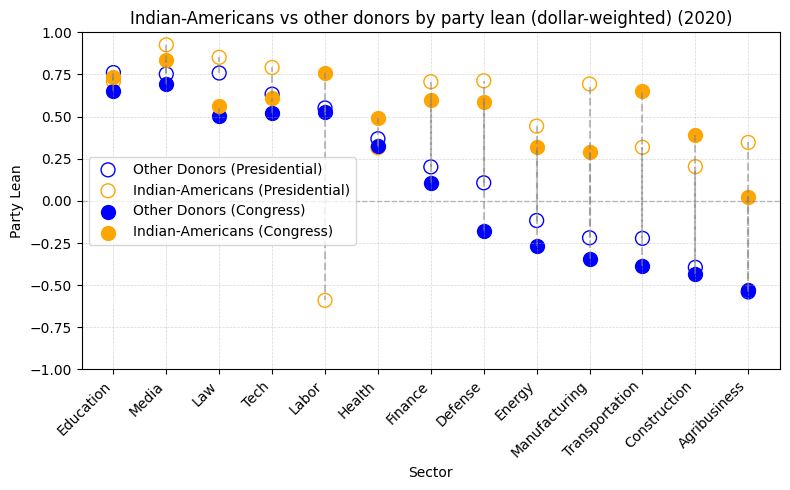

In [42]:
donors_lean_year = donors_pac_lean[donors_pac_lean["cycle"] == 2000 + year].sort_values(by="lean_other", ascending=False)
sectors = donors_lean_year[donors_lean_year["level"] == "President"]["sector"]

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, donors_lean_year[donors_lean_year["level"] == "President"]["dollar_lean_other"], donors_lean_year[donors_lean_year["level"] == "President"]["dollar_lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)
for cat, g1, g2 in zip(sectors, donors_lean_year[donors_lean_year["level"] == "House"]["dollar_lean_other"], donors_lean_year[donors_lean_year["level"] == "House"]["dollar_lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "President"]["dollar_lean_other"], facecolors='none', edgecolors='blue', label='Other Donors (Presidential)', s=100)
plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "President"]["dollar_lean_indian"], facecolors='none', edgecolors='orange', label='Indian-Americans (Presidential)', s=100)
plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "House"]["dollar_lean_other"], color="blue", label='Other Donors (Congress)', s=100)
plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "House"]["dollar_lean_indian"], color="orange",  label='Indian-Americans (Congress)', s=100)

plt.title(f"Indian-Americans vs other donors by party lean (dollar-weighted) (20{year})")
plt.xlabel("Sector")
plt.ylabel("Party Lean")
plt.xticks(rotation=45, ha='right')
plt.ylim(-1, 1)

plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0, color='grey', alpha=0.5, linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

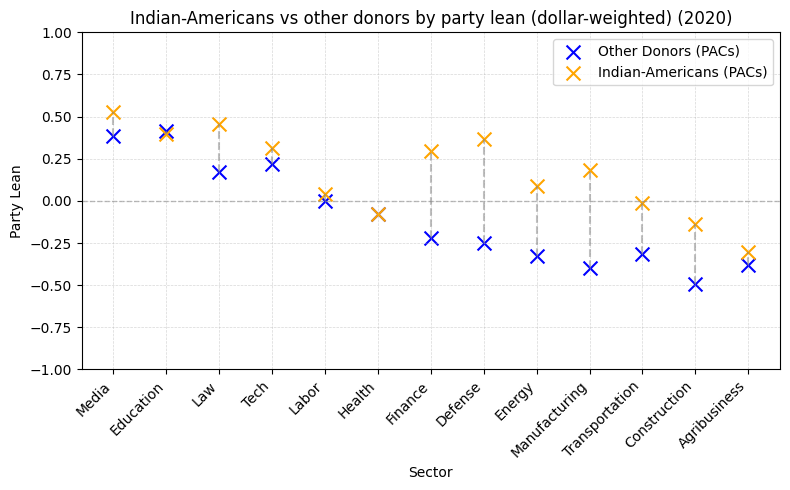

In [43]:
donors_lean_year = donors_pac_lean[donors_pac_lean["cycle"] == 2000 + year].sort_values(by="lean_other", ascending=False)
sectors = donors_lean_year[donors_lean_year["level"] == "PAC"]["sector"]

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, donors_lean_year[donors_lean_year["level"] == "PAC"]["dollar_lean_other"], donors_lean_year[donors_lean_year["level"] == "PAC"]["dollar_lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "PAC"]["dollar_lean_other"], marker="x", color="blue", label='Other Donors (PACs)', s=100)
plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "PAC"]["dollar_lean_indian"], marker="x", color="orange",  label='Indian-Americans (PACs)', s=100)

plt.title(f"Indian-Americans vs other donors by party lean (dollar-weighted) (20{year})")
plt.xlabel("Sector")
plt.ylabel("Party Lean")
plt.xticks(rotation=45, ha='right')
plt.ylim(-1, 1)

plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0, color='grey', alpha=0.5, linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

In [44]:
print("Overall, presidential: ", donors_pac_lean[(donors_pac_lean["cycle"] == 2000 + year) & (donors_pac_lean["level"] == "President")]["dollar_lean_other"].mean())
print("Indians, presidential: ", donors_pac_lean[(donors_pac_lean["cycle"] == 2000 + year) & (donors_pac_lean["level"] == "President")]["dollar_lean_indian"].mean())
print("Overall, congressional: ", donors_pac_lean[(donors_pac_lean["cycle"] == 2000 + year) & (donors_pac_lean["level"] == "House")]["dollar_lean_other"].mean())
print("Indians, congressional: ", donors_pac_lean[(donors_pac_lean["cycle"] == 2000 + year) & (donors_pac_lean["level"] == "House")]["dollar_lean_indian"].mean())
print("Overall, PAC: ", donors_pac_lean[(donors_pac_lean["cycle"] == 2000 + year) & (donors_pac_lean["level"] == "PAC")]["dollar_lean_other"].mean())
print("Indians, PAC: ", donors_pac_lean[(donors_pac_lean["cycle"] == 2000 + year) & (donors_pac_lean["level"] == "PAC")]["dollar_lean_indian"].mean())

Overall, presidential:  0.20341495221426878
Indians, presidential:  0.49442636374269266
Overall, congressional:  0.09212354142273814
Indians, congressional:  0.5272237108125418
Overall, PAC:  -0.09735283366311734
Indians, PAC:  0.16535238492413826


In [45]:
sectors_count = donors[~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])].groupby(['cycle', 'sector', 'indian', 'party']).agg(sum=('total_donated', 'sum'), count=('contrib_id', 'count')).reset_index()
sectors_count_pivot = sectors_count.pivot(index=['cycle', 'sector'], columns=['indian', 'party'], values=['sum', 'count']).fillna(0).reset_index()
sectors_count_pivot.columns = ['cycle', 'sector',
                      'sum_other_3', 'sum_other_d', 'sum_other_i', 'sum_other_l', 'sum_other_r',
                      'sum_indian_d', 'sum_indian_r', 'sum_indian_3', 'sum_other_u', 'sum_indian_l','sum_indian_i', 'sum_indian_u', 
                      'count_other_3', 'count_other_d', 'count_other_i', 'count_other_l', 'count_other_r', 
                      'count_indian_d', 'count_indian_r', 'count_indian_3', 'count_other_u', 'count_indian_l','count_indian_i', 'count_indian_u']
sectors_count_pivot[['cycle', 'sector', 'sum_other_d', 'sum_indian_d', 'sum_other_r', 'sum_indian_r', 'count_other_d', 'count_indian_d', 'count_other_r', 'count_indian_r']]

cycle          sector  sum_other_d  sum_indian_d  sum_other_r  \
0     2000    Agribusiness    4170916.0       15850.0   13042858.0   
1     2000    Construction   11638113.0      205956.0   26539950.0   
2     2000         Defense    1080237.0       19666.0    2115851.0   
3     2000       Education     433777.0        4300.0     284829.0   
4     2000          Energy    4282696.0       72500.0   15497240.0   
..     ...             ...          ...           ...          ...   
151   2022             Law  198233117.0     1578811.0   81546959.0   
152   2022   Manufacturing   12786963.0     1261845.0   41314986.0   
153   2022           Media   48192295.0      422693.0    8150058.0   
154   2022            Tech  146124992.0     2999439.0   46788812.0   
155   2022  Transportation   20556514.0      992867.0   52875637.0   

     sum_indian_r  count_other_d  count_indian_d  count_other_r  \
0         43400.0         4830.0            22.0        15014.0   
1        142011.0        11584.0           175.0        27278.0   
2         11700.0         1296.0            17.0         2518.0   
3          1300.0          719.0             7.0          444.0   
4         48900.0         4540.0            62.0        14358.0   
..            ...            ...             ...            ...   
151      350031.0       107736.0           896.0        46857.0   
152      117616.0         6226.0           257.0        12490.0   
153       30301.0        27843.0           224.0         6280.0   
154      455519.0        52431.0          1659.0        19837.0   
155      584560.0        12678.0           421.0        30845.0   

     count_indian_r  
0              53.0  
1             149.0  
2              15.0  
3               2.0  
4              52.0  
..              ...  
151           211.0  
152            77.0  
153            32.0  
154           328.0  
155           336.0  

[156 rows x 10 columns]

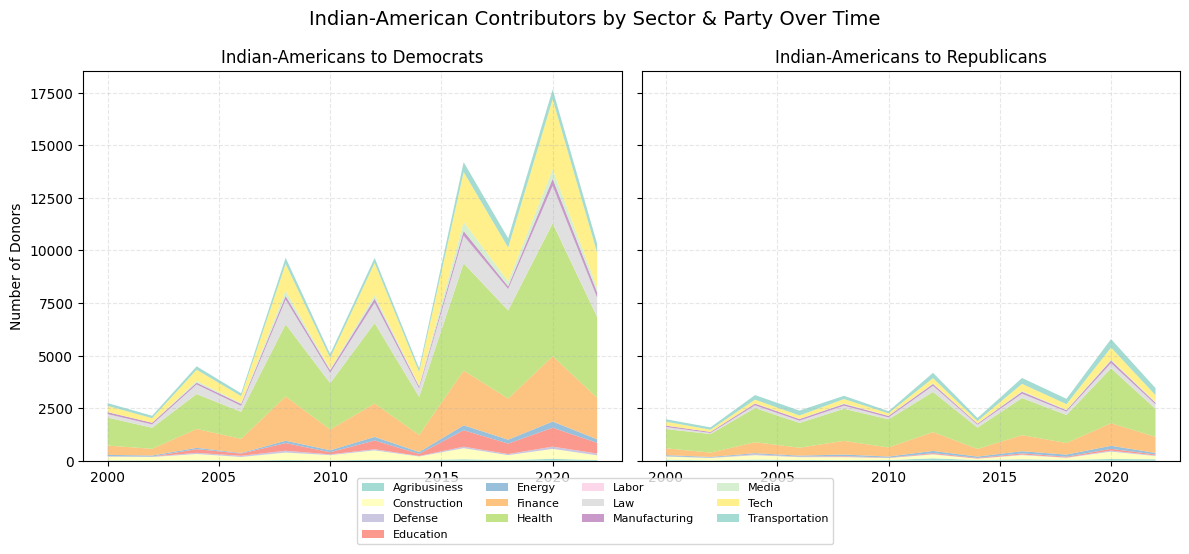

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sectors = sectors_count_pivot["sector"].unique()
colors = sns.color_palette("Set3", n_colors=len(sectors))

count_indian_d = sectors_count_pivot.pivot(index='cycle', columns='sector', values='count_indian_d')
count_indian_r = sectors_count_pivot.pivot(index='cycle', columns='sector', values='count_indian_r')

ax1.stackplot(
    count_indian_d.index,
    count_indian_d.T,
    labels=sectors,
    colors=colors,
    alpha=0.8,
)
ax1.set_title("Indian-Americans to Democrats", fontsize=12)
ax1.set_ylabel("Number of Donors")
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.stackplot(
    count_indian_r.index,
    count_indian_r.T,
    labels=sectors,
    colors=colors,
    alpha=0.8,
)
ax2.set_title("Indian-Americans to Republicans", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8
)

plt.suptitle("Indian-American Contributors by Sector & Party Over Time", fontsize=14)
plt.tight_layout()
plt.show()

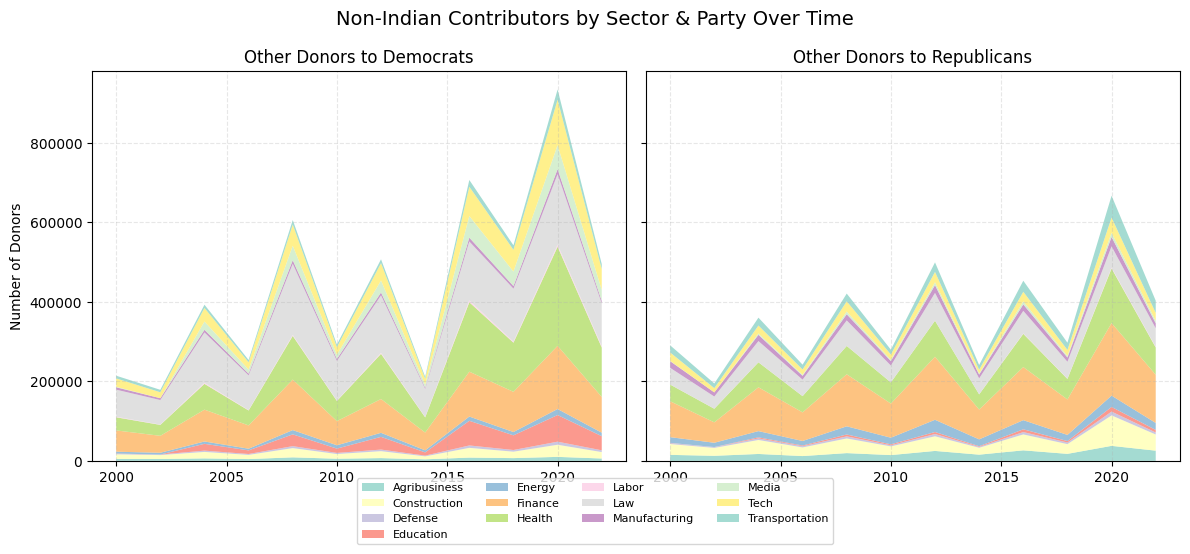

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

count_other_d = sectors_count_pivot.pivot(index='cycle', columns='sector', values='count_other_d')
count_other_r = sectors_count_pivot.pivot(index='cycle', columns='sector', values='count_other_r')

ax1.stackplot(
    count_other_d.index,
    count_other_d.T,
    labels=sectors,
    colors=colors,
    alpha=0.8,
)
ax1.set_title("Other Donors to Democrats", fontsize=12)
ax1.set_ylabel("Number of Donors")
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.stackplot(
    count_other_r.index,
    count_other_r.T,
    labels=sectors,
    colors=colors,
    alpha=0.8,
)
ax2.set_title("Other Donors to Republicans", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8
)

plt.suptitle("Non-Indian Contributors by Sector & Party Over Time", fontsize=14)
plt.tight_layout()
plt.show()

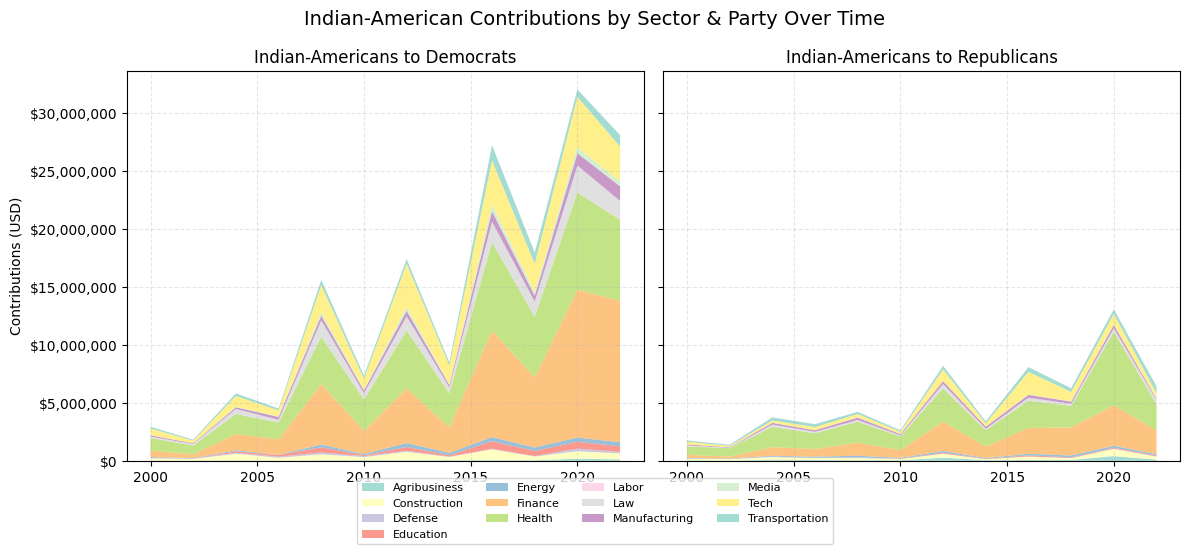

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sum_indian_d = sectors_count_pivot.pivot(index='cycle', columns='sector', values='sum_indian_d')
sum_indian_r = sectors_count_pivot.pivot(index='cycle', columns='sector', values='sum_indian_r')

ax1.stackplot(
    sum_indian_d.index,
    sum_indian_d.T,
    labels=sectors,
    colors=colors,
    alpha=0.8,
)
ax1.set_title("Indian-Americans to Democrats", fontsize=12)
ax1.set_ylabel("Contributions (USD)")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.stackplot(
    sum_indian_r.index,
    sum_indian_r.T,
    labels=sectors,
    colors=colors,
    alpha=0.8,
)
ax2.set_title("Indian-Americans to Republicans", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8
)

plt.suptitle("Indian-American Contributions by Sector & Party Over Time", fontsize=14)
plt.tight_layout()
plt.show()

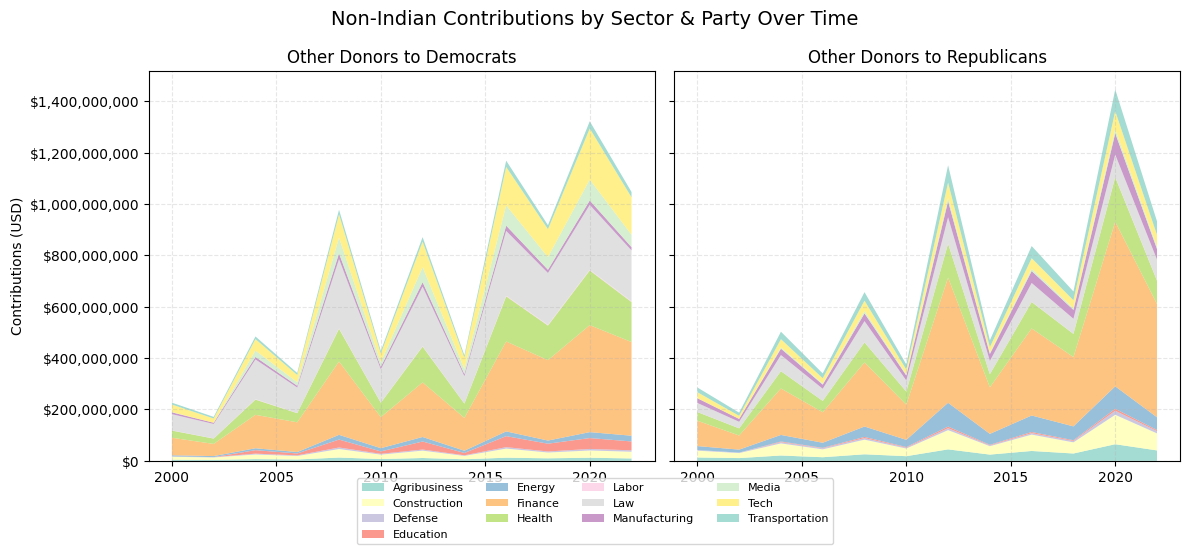

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sum_other_d = sectors_count_pivot.pivot(index='cycle', columns='sector', values='sum_other_d')
sum_other_r = sectors_count_pivot.pivot(index='cycle', columns='sector', values='sum_other_r')

ax1.stackplot(
    sum_other_d.index,
    sum_other_d.T,
    labels=sectors,
    colors=colors,
    alpha=0.8,
)
ax1.set_title("Other Donors to Democrats", fontsize=12)
ax1.set_ylabel("Contributions (USD)")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.stackplot(
    sum_other_r.index,
    sum_other_r.T,
    labels=sectors,
    colors=colors,
    alpha=0.8,
)
ax2.set_title("Other Donors to Republicans", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8
)

plt.suptitle("Non-Indian Contributions by Sector & Party Over Time", fontsize=14)
plt.tight_layout()
plt.show()

In [50]:
key_states = ['CA', 'TX', 'IL', 'NY', 'NJ', 'FL', 'VA', 'MA', 'WA']

states_count = donors.groupby(['cycle', 'state', 'indian', 'party']).agg(sum=('total_donated', 'sum'), count=('contrib_id', 'count')).reset_index()
states_count_pivot = states_count.pivot(index=['cycle', 'state'], columns=['indian', 'party'], values=['sum', 'count']).fillna(0).reset_index()
states_count_pivot.columns = ['cycle', 'state',
                      'sum_other_3', 'sum_other_d', 'sum_other_i', 'sum_other_l', 'sum_other_r',
                      'sum_indian_d', 'sum_indian_r', 'sum_other_u', 'sum_indian_3', 'sum_indian_l','sum_indian_i', 'sum_indian_u', 
                      'count_other_3', 'count_other_d', 'count_other_i', 'count_other_l', 'count_other_r', 
                      'count_indian_d', 'count_indian_r', 'count_other_u', 'count_indian_3', 'count_indian_l','count_indian_i', 'count_indian_u']

states_count_pivot['state'] = states_count_pivot['state'].where(states_count_pivot['state'].isin(key_states), 'Others')
states_count_pivot = states_count_pivot.groupby(['cycle', 'state']
).agg({
    'sum_other_d': 'sum',
    'sum_indian_d': 'sum',
    'sum_other_r': 'sum',
    'sum_indian_r': 'sum',
    'count_other_d': 'sum',
    'count_indian_d': 'sum',
    'count_other_r': 'sum',
    'count_indian_r': 'sum'
}).reset_index()

states_count_pivot

cycle   state   sum_other_d  sum_indian_d   sum_other_r  sum_indian_r  \
0     2000      CA  5.499639e+07     1091465.0  5.569932e+07      528447.0   
1     2000      FL  2.036281e+07      213031.0  3.505900e+07      284504.0   
2     2000      IL  1.747894e+07      239717.0  1.723208e+07      103715.0   
3     2000      MA  1.687841e+07      122875.0  7.390609e+06       19220.0   
4     2000      NJ  2.129145e+07      436903.0  2.257166e+07      207925.0   
..     ...     ...           ...           ...           ...           ...   
115   2022      NY  3.857655e+08     6910789.0  1.513152e+08     1130674.0   
116   2022  Others  1.305246e+09    12819058.0  1.307181e+09     5749947.0   
117   2022      TX  1.150505e+08     2769934.0  2.859034e+08     1633580.0   
118   2022      VA  8.270382e+07     2136685.0  2.410354e+08      333934.0   
119   2022      WA  1.089206e+08     1685173.0  6.104560e+07      180769.0   

     count_other_d  count_indian_d  count_other_r  count_indian_r  
0          49685.0           766.0        58642.0           538.0  
1          19277.0           230.0        36566.0           341.0  
2          17597.0           233.0        20115.0           137.0  
3          17682.0           116.0         8225.0            20.0  
4          21531.0           534.0        24942.0           225.0  
..             ...             ...            ...             ...  
115       200106.0          2948.0       100014.0           935.0  
116       988092.0          9726.0      1310796.0          5362.0  
117        90447.0          1645.0       250208.0          1240.0  
118        70489.0          1175.0        81619.0           331.0  
119        97707.0           811.0        77887.0           216.0  

[120 rows x 10 columns]

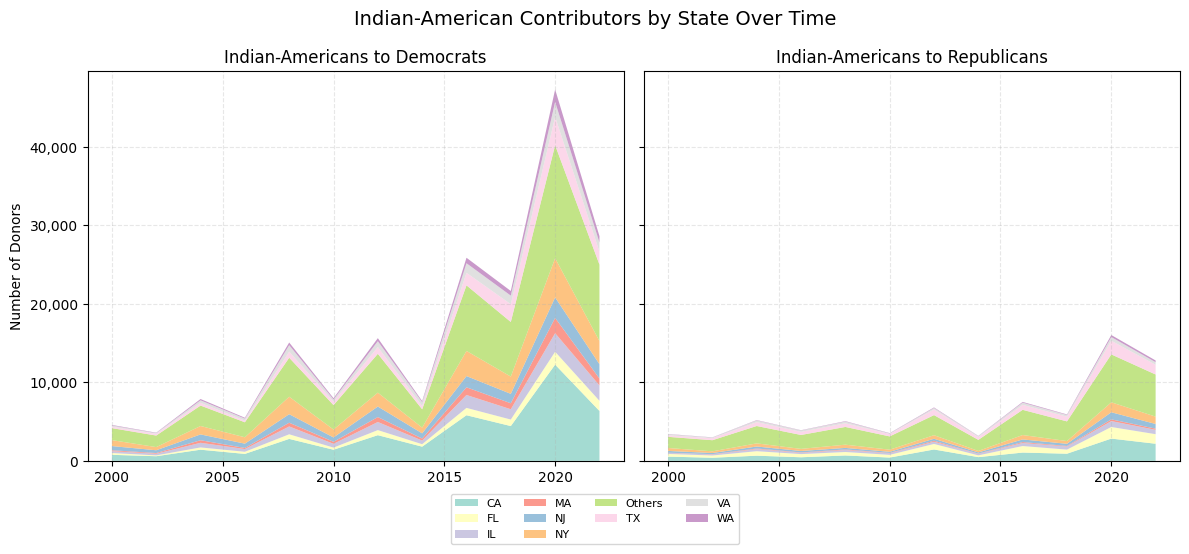

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

state_names = states_count_pivot["state"].unique()
colors = sns.color_palette("Set3", n_colors=len(state_names))

count_indian_d = states_count_pivot.pivot(index='cycle', columns='state', values='count_indian_d')
# sum_indian_d = sum_indian_d.div(sum_indian_d.sum(axis=1), axis=0) * 100
count_indian_r = states_count_pivot.pivot(index='cycle', columns='state', values='count_indian_r')
# sum_indian_r = sum_indian_r.div(sum_indian_r.sum(axis=1), axis=0) * 100

ax1.stackplot(
    count_indian_d.index,
    count_indian_d.T,
    labels=state_names,
    colors=colors,
    alpha=0.8,
)
ax1.set_title("Indian-Americans to Democrats", fontsize=12)
ax1.set_ylabel("Number of Donors")
# ax1.set_ylim(0, 100)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.stackplot(
    count_indian_r.index,
    count_indian_r.T,
    labels=state_names,
    colors=colors,
    alpha=0.8,
)
ax2.set_title("Indian-Americans to Republicans", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8
)

plt.suptitle("Indian-American Contributors by State Over Time", fontsize=14)
plt.tight_layout()
plt.show()

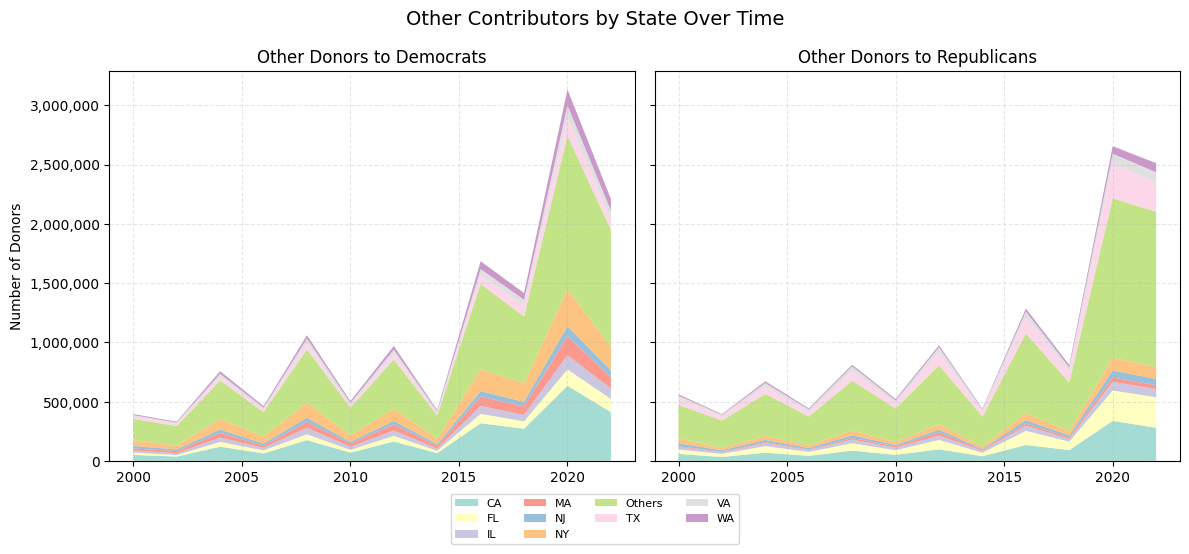

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

count_other_d = states_count_pivot.pivot(index='cycle', columns='state', values='count_other_d')
# sum_indian_d = sum_indian_d.div(sum_indian_d.sum(axis=1), axis=0) * 100
count_other_r = states_count_pivot.pivot(index='cycle', columns='state', values='count_other_r')
# sum_indian_r = sum_indian_r.div(sum_indian_r.sum(axis=1), axis=0) * 100

ax1.stackplot(
    count_other_d.index,
    count_other_d.T,
    labels=state_names,
    colors=colors,
    alpha=0.8,
)
ax1.set_title("Other Donors to Democrats", fontsize=12)
ax1.set_ylabel("Number of Donors")
# ax1.set_ylim(0, 100)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.stackplot(
    count_other_r.index,
    count_other_r.T,
    labels=state_names,
    colors=colors,
    alpha=0.8,
)
ax2.set_title("Other Donors to Republicans", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8
)

plt.suptitle("Other Contributors by State Over Time", fontsize=14)
plt.tight_layout()
plt.show()

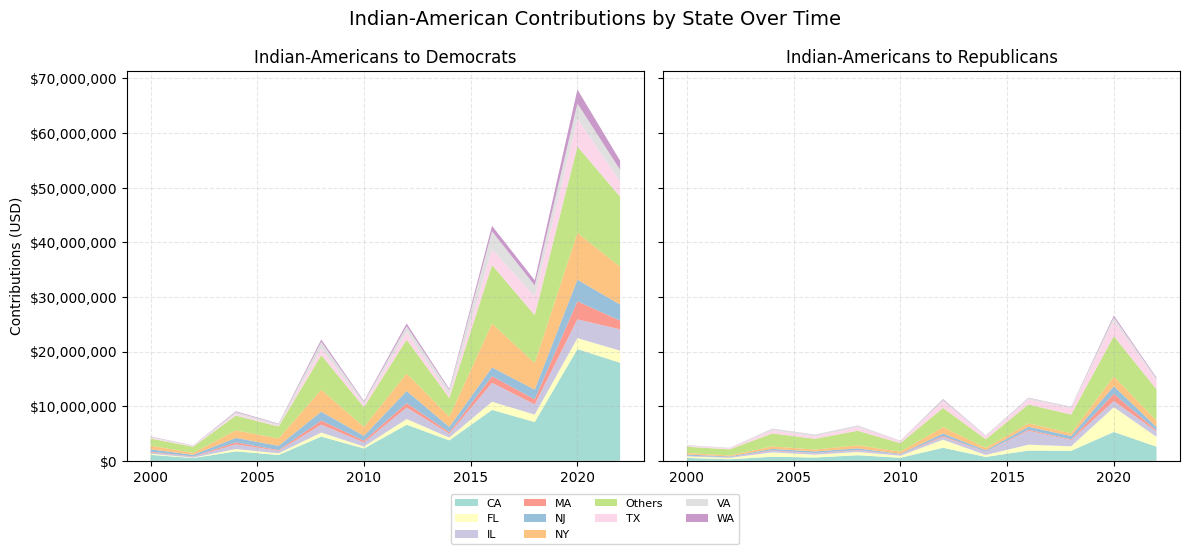

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sum_indian_d = states_count_pivot.pivot(index='cycle', columns='state', values='sum_indian_d')
# sum_indian_d = sum_indian_d.div(sum_indian_d.sum(axis=1), axis=0) * 100
sum_indian_r = states_count_pivot.pivot(index='cycle', columns='state', values='sum_indian_r')
# sum_indian_r = sum_indian_r.div(sum_indian_r.sum(axis=1), axis=0) * 100

ax1.stackplot(
    sum_indian_d.index,
    sum_indian_d.T,
    labels=state_names,
    colors=colors,
    alpha=0.8,
)
ax1.set_title("Indian-Americans to Democrats", fontsize=12)
ax1.set_ylabel("Contributions (USD)")
# ax1.set_ylim(0, 100)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.stackplot(
    sum_indian_r.index,
    sum_indian_r.T,
    labels=state_names,
    colors=colors,
    alpha=0.8,
)
ax2.set_title("Indian-Americans to Republicans", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8
)

plt.suptitle("Indian-American Contributions by State Over Time", fontsize=14)
plt.tight_layout()
plt.show()

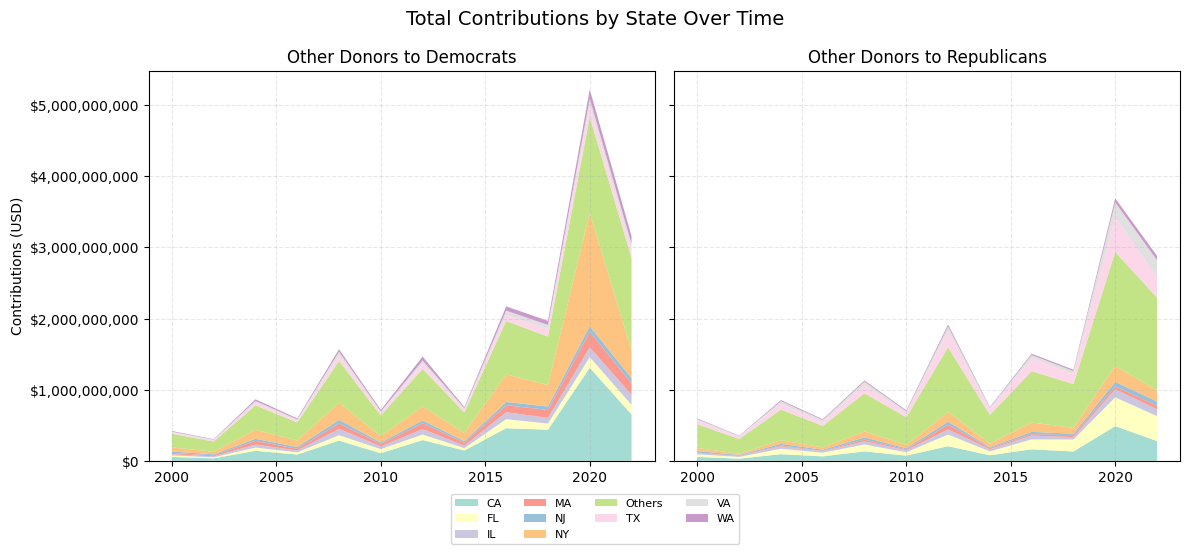

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sum_other_d = states_count_pivot.pivot(index='cycle', columns='state', values='sum_other_d')
# sum_other_d = sum_other_d.div(sum_other_d.sum(axis=1), axis=0) * 100
sum_other_r = states_count_pivot.pivot(index='cycle', columns='state', values='sum_other_r')
# sum_other_r = sum_other_r.div(sum_other_r.sum(axis=1), axis=0) * 100

ax1.stackplot(
    sum_other_d.index,
    sum_other_d.T,
    labels=state_names,
    colors=colors,
    alpha=0.8,
)
ax1.set_title("Other Donors to Democrats", fontsize=12)
ax1.set_ylabel("Contributions (USD)")
# ax1.set_ylim(0, 100)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.stackplot(
    sum_other_r.index,
    sum_other_r.T,
    labels=state_names,
    colors=colors,
    alpha=0.8,
)
ax2.set_title("Other Donors to Republicans", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8
)

plt.suptitle("Total Contributions by State Over Time", fontsize=14)
plt.tight_layout()
plt.show()

In [55]:
donors[(donors["cycle"] == 2020) & (donors["indian"] == True)].groupby(["name_y"])["total_donated"].sum().sort_values(ascending=False)[40:60]

name_y
Nancy Pelosi Victory Fund                  455100.0
Unite the Country                          438900.0
Sara Gideon (D)                            431423.0
Democratic Party of Wisconsin              382456.0
National Republican Senatorial Cmte        360767.0
Rishi Kumar (D)                            338588.0
Mark Warner (D)                            337020.0
Cal Cunningham (D)                         322883.0
Michigan Democratic State Central Cmte     319154.0
Democratic Party of Texas                  295982.0
The IMPACT Fund                            295000.0
Tech for Campaigns                         290887.0
Lindsey Graham (R)                         287352.0
The Lincoln Project                        277464.0
Amy McGrath (D)                            274447.0
Democratic Party of Arizona                262152.0
Hiral Tipirneni (D)                        254612.0
Amy Klobuchar (D)                          254418.0
Minnesota Democratic Farmer Labor Party    253110.0
Democ

In [56]:
indian_donations = donors[(donors["indian"] == True)].groupby(["cycle", "name_y", "seat"])["total_donated"].sum()
total_donations = donors.groupby(["cycle", "name_y", "seat"])["total_donated"].sum()
eligible_candidates = total_donations[total_donations >= 10000]
percentage_indian_donations = (indian_donations / total_donations * 100).fillna(0)
percentage_indian_donations = percentage_indian_donations[percentage_indian_donations.index.isin(eligible_candidates.index)]

In [57]:
output = percentage_indian_donations.sort_values(ascending=False).reset_index()

indian_donations = indian_donations.reset_index()
total_donations = total_donations.reset_index()

output = percentage_indian_donations.reset_index()
output.columns = ["cycle", "name_y", "seat", "percentage_indian_donations"]

output = output.merge(total_donations, on=["cycle", "name_y", "seat"], how="left")
output = output.merge(indian_donations, on=["cycle", "name_y", "seat"], how="left")
output.rename(columns={"total_donated_x": "total_raised", "total_donated_y": "raised_from_indian"}, inplace=True)


In [58]:
output.sort_values(by="percentage_indian_donations", ascending=False)[:20]

cycle                  name_y  seat  percentage_indian_donations  \
10844   2014      Satish W Korpe (D)  VA08                   100.000000   
9586    2012         Vipin Verma (D)  FL06                   100.000000   
8147    2012          Bill Maske (D)  IA04                   100.000000   
16275   2022    Abhiram Garapati (R)  TX31                   100.000000   
4630    2006           Ro Khanna (D)  CA12                   100.000000   
18069   2022       Rostislav Rar (D)  NY20                   100.000000   
16984   2022          Gary Barve (R)  VA07                   100.000000   
15033   2020          Emily Rafi (R)  MI03                   100.000000   
10815   2014          Ron Sanyal (D)  NC13                   100.000000   
14216   2018     Shiva Ayyadurai (I)  MAS1                    97.438622   
13063   2018      Dushyant Gosai (D)  FL03                    92.341077   
14418   2018     Vandana Jhingan (R)  IL08                    89.743590   
16053   2020     Shiva Ayyadurai (R)  MAS2                    89.477724   
18023   2022       Ritesh Tandon (R)  CA17                    88.341463   
13375   2018  Jitendra Diganvker (R)  IL08                    87.380342   
14278   2018         Suraj Patel (D)  NY12                    86.453000   
15926   2020       Ritesh Tandon (R)  CA17                    86.067010   
15806   2020        Nisha Sharma (R)  CA11                    86.061606   
15520   2020      Krishna Bansal (R)  IL11                    83.679963   
17601   2022     Mahesh Ganorkar (R)  NC02                    83.102493   

       total_raised  raised_from_indian  
10844       10478.0             10478.0  
9586        28288.0             28288.0  
8147        12200.0             12200.0  
16275       19150.0             19150.0  
4630        13181.0             13181.0  
18069       14600.0             14600.0  
16984       10917.0             10917.0  
15033       26586.0             26586.0  
10815       13830.0             13830.0  
14216     4955184.0           4828263.0  
13063       19585.0             18085.0  
14418       62400.0             56000.0  
16053     1170013.0           1046901.0  
18023       97791.0             86390.0  
13375       51919.0             45367.0  
14278     2253296.0           1948042.0  
15926       72497.0             62396.0  
15806       72103.0             62053.0  
15520      182904.0            153054.0  
17601       18050.0             15000.0

In [59]:
output[(output["name_y"] == "Kamala Harris (D)")].sort_values(by="percentage_indian_donations", ascending=False)[:20]

cycle             name_y  seat  percentage_indian_donations  \
15448   2020  Kamala Harris (D)  CAS1                     2.874006   

       total_raised  raised_from_indian  
15448    32280695.0            927749.0

In [60]:
presidents_data = {
    'metric': ['Indians', 'Total', 'Percentage'],
    'Al Gore': [269791, 34559984, 0.780646],
    'Bush (2000)': [560843, 86580428, 0.647771],
    'John Kerry': [1920921, 167669770, 1.145657],
    'Bush (2004)': [1428910, 196193122, 0.728318],
    'Obama (2008)': [5526132, 419409348, 1.317599],
    'John McCain': [1378487, 193655760, 0.711823],
    'Obama (2012)': [4721608, 332942168, 1.418147],
    'Mitt Romney': [2344496, 370659757, 0.632520],
    'Hillary Clinton': [8702217, 434582745, 2.002430],
    'Trump (2016)': [710060, 126558263, 0.561054],
    'Joe Biden': [10753423, 681837529, 1.577124],
    'Trump (2020)': [3790348, 476382132, 0.795653]
}

presidents = pd.DataFrame(presidents_data).T
presidents.columns = presidents.iloc[0]
presidents = presidents.iloc[1:]
presidents

metric              Indians        Total Percentage
Al Gore            269791.0   34559984.0   0.780646
Bush (2000)        560843.0   86580428.0   0.647771
John Kerry        1920921.0  167669770.0   1.145657
Bush (2004)       1428910.0  196193122.0   0.728318
Obama (2008)      5526132.0  419409348.0   1.317599
John McCain       1378487.0  193655760.0   0.711823
Obama (2012)      4721608.0  332942168.0   1.418147
Mitt Romney       2344496.0  370659757.0    0.63252
Hillary Clinton   8702217.0  434582745.0    2.00243
Trump (2016)       710060.0  126558263.0   0.561054
Joe Biden        10753423.0  681837529.0   1.577124
Trump (2020)      3790348.0  476382132.0   0.795653

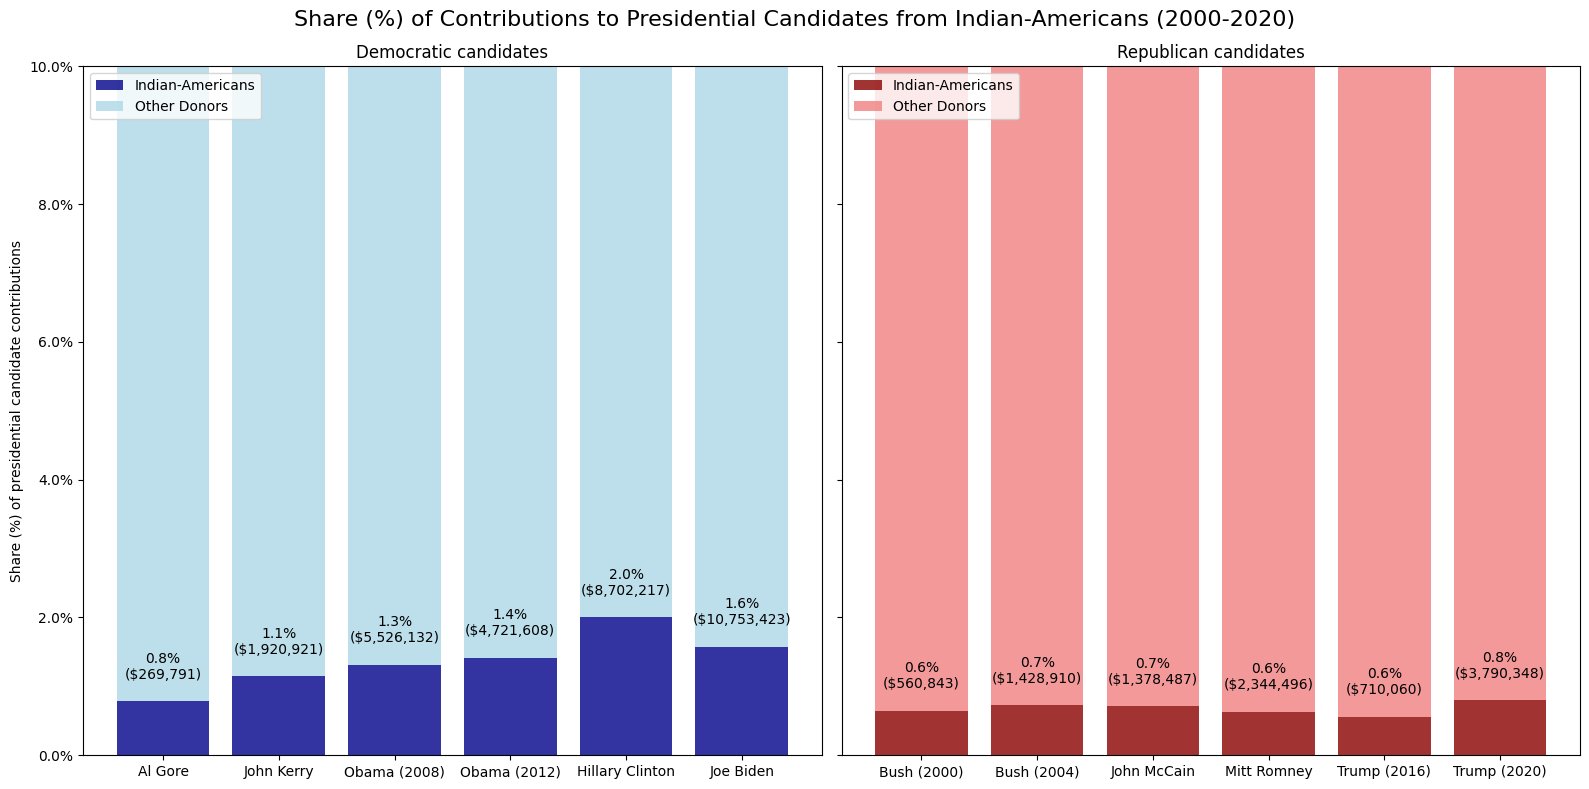

In [61]:
presidents['Other Donors'] = presidents['Total'] - presidents['Indians']
presidents['Indian_Pct'] = (presidents['Indians'] / presidents['Total']) * 100
presidents['Non_Indian_Pct'] = 100 - presidents['Indian_Pct']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Left subplot: Dark blue and light blue for alternating rows (starting from the first)
bars2_ax1 = ax1.bar(
    presidents.index[::2], 
    presidents['Indian_Pct'][::2], 
    label='Indian-Americans', 
    alpha=0.8, 
    color='darkblue'
)
bars1_ax1 = ax1.bar(
    presidents.index[::2], 
    presidents['Non_Indian_Pct'][::2], 
    bottom=presidents['Indian_Pct'][::2], 
    label='Other Donors', 
    alpha=0.8, 
    color='lightblue'
)

# Add text annotations for the left subplot
for i, metric in enumerate(presidents.index[::2]):
    indian_pct = presidents.loc[metric, 'Indian_Pct']
    ax1.text(
        i, 
        presidents.loc[metric, 'Indian_Pct'] + 0.5, 
        f'{indian_pct:.1f}%\n(${int(presidents.loc[metric, 'Indians']):,.0f})', 
        ha='center', 
        va='center', 
        color='white' if indian_pct > 30 else 'black'
    )

ax1.set_ylabel('Share (%) of presidential candidate contributions')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.1f}%'))
ax1.set_ylim(0, 10)
ax1.set_title('Democratic candidates')
ax1.legend(loc='upper left')

# Right subplot: Shades of red for alternating rows (starting from the second)
bars2_ax2 = ax2.bar(
    presidents.index[1::2], 
    presidents['Indian_Pct'][1::2], 
    label='Indian-Americans', 
    alpha=0.8, 
    color='darkred'
)
bars1_ax2 = ax2.bar(
    presidents.index[1::2], 
    presidents['Non_Indian_Pct'][1::2], 
    bottom=presidents['Indian_Pct'][1::2], 
    label='Other Donors', 
    alpha=0.8, 
    color='lightcoral'
)

# Add text annotations for the right subplot
for i, metric in enumerate(presidents.index[1::2]):
    indian_pct = presidents.loc[metric, 'Indian_Pct']
    ax2.text(
        i, 
        presidents.loc[metric, 'Indian_Pct'] + 0.5, 
        f'{indian_pct:.1f}%\n(${int(presidents.loc[metric, 'Indians']):,.0f})', 
        ha='center', 
        va='center', 
        color='white' if indian_pct > 30 else 'black'
    )

ax2.set_ylim(0, 10)
ax2.set_title('Republican candidates')
ax2.legend(loc='upper left')
plt.suptitle('Share (%) of Contributions to Presidential Candidates from Indian-Americans (2000-2020)', fontsize=16)

plt.tight_layout()
plt.show()

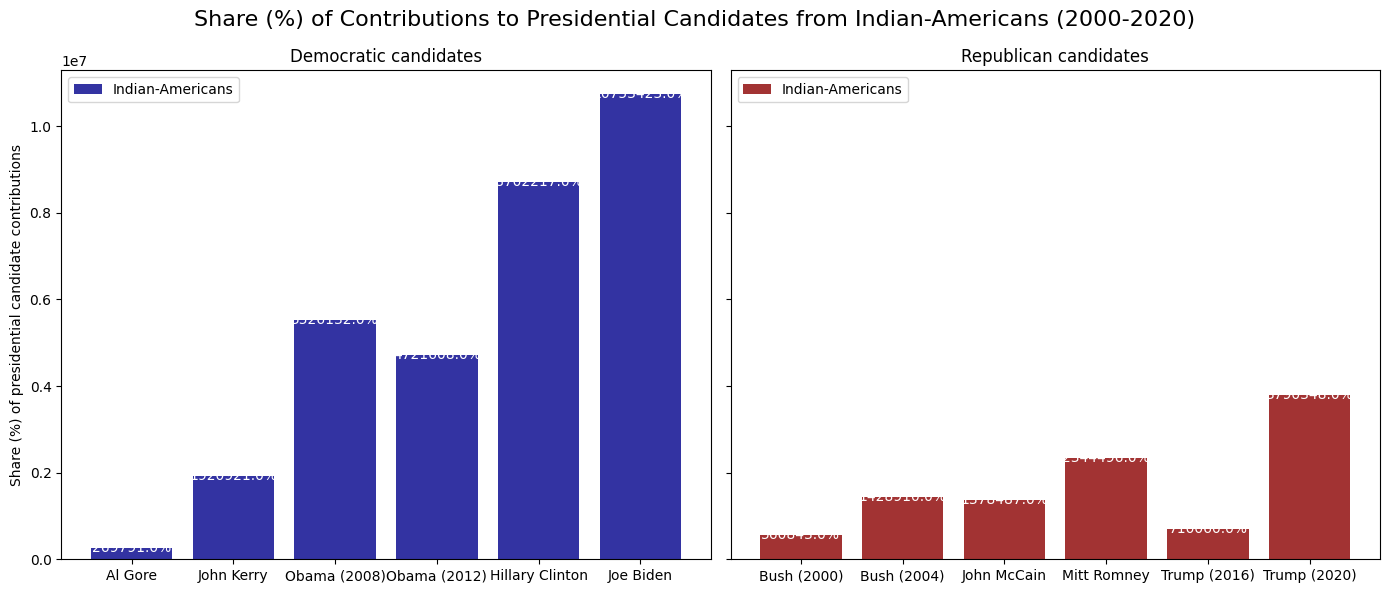

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Left subplot: Dark blue and light blue for alternating rows (starting from the first)
bars2_ax1 = ax1.bar(
    presidents.index[::2], 
    presidents['Indians'][::2], 
    label='Indian-Americans', 
    alpha=0.8, 
    color='darkblue'
)

# Add text annotations for the left subplot
for i, metric in enumerate(presidents.index[::2]):
    indian_pct = presidents.loc[metric, 'Indians']
    ax1.text(
        i, 
        presidents.loc[metric, 'Indians'] + 0.5, 
        f'{indian_pct:.1f}%', 
        ha='center', 
        va='center', 
        color='white' if indian_pct > 30 else 'black'
    )

ax1.set_ylabel('Share (%) of presidential candidate contributions')
ax1.set_title('Democratic candidates')
ax1.legend(loc='upper left')

# Right subplot: Shades of red for alternating rows (starting from the second)
bars2_ax2 = ax2.bar(
    presidents.index[1::2], 
    presidents['Indians'][1::2], 
    label='Indian-Americans', 
    alpha=0.8, 
    color='darkred'
)

# Add text annotations for the right subplot
for i, metric in enumerate(presidents.index[1::2]):
    indian_pct = presidents.loc[metric, 'Indians']
    ax2.text(
        i, 
        presidents.loc[metric, 'Indians'] + 0.5, 
        f'{indian_pct:.1f}%', 
        ha='center', 
        va='center', 
        color='white' if indian_pct > 30 else 'black'
    )

ax2.set_title('Republican candidates')
ax2.legend(loc='upper left')
plt.suptitle('Share (%) of Contributions to Presidential Candidates from Indian-Americans (2000-2020)', fontsize=16)

plt.tight_layout()
plt.show()

In [86]:
output[(output["seat"] != "PRES") & (output["raised_from_indian"] >= 100000)].sort_values(by="percentage_indian_donations", ascending=False)[:20]

cycle                   name_y  seat  percentage_indian_donations  \
14216   2018      Shiva Ayyadurai (I)  MAS1                    97.438622   
16053   2020      Shiva Ayyadurai (R)  MAS2                    89.477724   
14278   2018          Suraj Patel (D)  NY12                    86.453000   
15520   2020       Krishna Bansal (R)  IL11                    83.679963   
16096   2020          Suraj Patel (D)  NY12                    82.007105   
18224   2022          Suraj Patel (D)  NY12                    80.820389   
3390    2004            Ro Khanna (D)  CA12                    79.513413   
15923   2020          Rishi Kumar (D)  CA18                    76.734346   
12189   2016           Ravi Patel (D)  IA01                    76.388684   
10937   2014       Swati Dandekar (D)  IA01                    72.593653   
18104   2022   Sandeep Srivastava (D)  TX03                    69.097253   
10491   2014           Manju Goel (R)  IL08                    69.061868   
13217   2018          Harry Arora (R)  CT04                    67.472148   
18020   2022          Rishi Kumar (D)  CA16                    64.824570   
13002   2018            Deep Sran (D)  VA10                    60.394361   
11029   2014  Upendra J Chirukula (D)  NJ07                    59.926069   
9579    2012  Upendra J Chirukula (D)  NJ07                    58.503311   
11071   2016          Abhay Patel (R)  LAS2                    56.534783   
17859   2022           Neal Walia (D)  CO01                    55.747907   
11032   2014         Vanila Singh (R)  CA17                    55.728116   

       total_raised  raised_from_indian  
14216     4955184.0           4828263.0  
16053     1170013.0           1046901.0  
14278     2253296.0           1948042.0  
15520      182904.0            153054.0  
16096     1840043.0           1508966.0  
18224     2557909.0           2067312.0  
3390       321957.0            255999.0  
15923      441247.0            338588.0  
12189     1110908.0            848608.0  
10937      573473.0            416305.0  
18104      157342.0            108719.0  
10491      231268.0            159718.0  
13217      490721.0            331100.0  
18020      695150.0            450628.0  
13002      387614.0            234097.0  
11029      332473.0            199238.0  
9579       780790.0            456788.0  
11071      424643.0            240071.0  
17859      268837.0            149871.0  
11032      304306.0            169584.0

In [64]:
donors[(donors["name_y"].isin(["Ro Khanna (D)"])) & (donors["cycle"] >= 2000) & (donors["indian"] == True)]

contrib_id   recip_id         name_new realcode gender  \
2182427   h3001222650   N00026427     rohit khanna    Z9000      N   
2325890   h3003499295   N00026427        kim singh    Y4000      N   
2330327   b0608487397   N00026427    subroto kundu    H1100      N   
2332867   h1001174607   N00026427   kiran malhotra    G0000      N   
2337004   f1000691396   N00026427     dhruv khanna    G2820      N   
...                ...        ...              ...      ...    ...   
31576077  m0001225924   N00026427    gopi kallayil    C6300      M   
31847019  j1001702644   N00026427     vijaya nabar    X1200      N   
31981771  p0003606179   N00026427      vinod mehra    X1200      M   
32424850  r0003799929   N00026427      priya desai    Z9500      N   
32546974  r0001617238   N00026427  sajad ghanizada    Z9500      M   

                  occupation          city state  total_donated  \
2182427             ATTORNEY     SAN MATEO    CA        59425.0   
2325890             ENGINEER     LOS ALTOS    CA         2250.0   
2330327            PHYSICIAN    PLEASANTON    CA         2000.0   
2332867          ENTREPENEUR      SARATOGA    CA         2000.0   
2337004          ENTREPENEUR     PALO ALTO    CA         2000.0   
...                      ...           ...   ...            ...   
31576077  BUSINESS EXECUTIVE  REDWOOD CITY    CA          100.0   
31847019        NOT EMPLOYED       PHOENIX    AZ           65.0   
31981771        NOT EMPLOYED       ROSELLE    IL           50.0   
32424850                 NaN    WASHINGTON    DC           15.0   
32546974                 NaN    WASHINGTON    DC            1.0   

          donation_count  ...  ran_general               type cmte_id  \
2182427               11  ...               Top 10,000 Donors     NaN   
2325890                2  ...                    Other Donors     NaN   
2330327                1  ...                    Other Donors     NaN   
2332867                1  ...                    Other Donors     NaN   
2337004                1  ...               Top 10,000 Donors     NaN   
...                  ...  ...          ...                ...     ...   
31576077               1  ...            Y       Other Donors     NaN   
31847019               4  ...            Y       Other Donors     NaN   
31981771               5  ...            Y       Other Donors     NaN   
32424850               1  ...            Y       Other Donors     NaN   
32546974               1  ...            Y       Other Donors     NaN   

          pac_short  recip_id_pac  cand_id recip_is_pac dem_ratio  level  \
2182427         NaN           NaN      NaN        False       1.0  House   
2325890         NaN           NaN      NaN        False       1.0  House   
2330327         NaN           NaN      NaN        False       1.0  House   
2332867         NaN           NaN      NaN        False       1.0  House   
2337004         NaN           NaN      NaN        False       1.0  House   
...             ...           ...      ...          ...       ...    ...   
31576077        NaN           NaN      NaN        False       1.0  House   
31847019        NaN           NaN      NaN        False       1.0  House   
31981771        NaN           NaN      NaN        False       1.0  House   
32424850        NaN           NaN      NaN        False       1.0  House   
32546974        NaN           NaN      NaN        False       1.0  House   

         dollar_lean  
2182427      59425.0  
2325890       2250.0  
2330327       2000.0  
2332867       2000.0  
2337004       2000.0  
...              ...  
31576077       100.0  
31847019        65.0  
31981771        50.0  
32424850        15.0  
32546974         1.0  

[2697 rows x 29 columns]

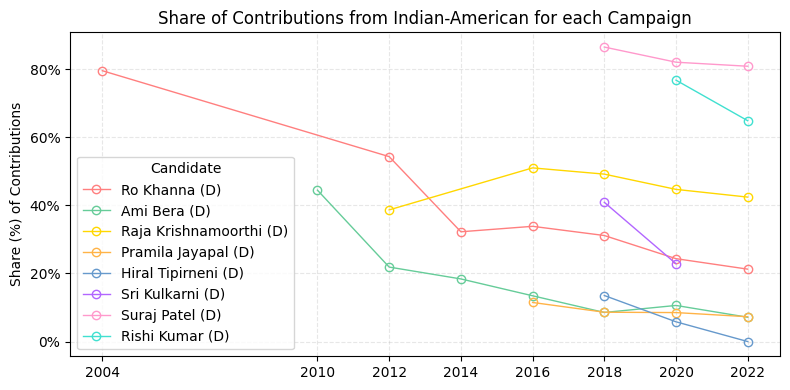

In [65]:
plt.figure(figsize=(8, 4))

cycles = donors["cycle"].unique()[2:]
cycles = np.concatenate((cycles[:1], cycles[3:]))
colors = [
    "#FF7F7F",  # Soft Red
    "#66CC99",  # Soft Orange
    "#FFD700",  # Soft Yellow
    "#FFB347",  # Soft Green
    "#6699CC",  # Soft Blue
    "#B266FF",  # Soft Purple
    "#FF99CC",  # Soft Pink
    "#40E0D0"   # Soft Cyan
]

# Plot one line per unique name_y
for index, name in enumerate(output[output["name_y"].isin(["Hiral Tipirneni (D)", "Suraj Patel (D)", "Sri Kulkarni (D)", "Pramila Jayapal (D)", "Raja Krishnamoorthi (D)", "Ami Bera (D)", "Ro Khanna (D)", "Rishi Kumar (D)", ""])]["name_y"].unique()):
    candidate_data = output[(output["name_y"] == name) & ~(output["cycle"].isin([2006, 2008]))]
    plt.plot(
        candidate_data["cycle"],
        candidate_data["percentage_indian_donations"],
        marker="o",
        markerfacecolor="none",
        linewidth=1,
        label=name,
        color=colors[index]
    )

# Add labels, title, and legend
plt.title("Share of Contributions from Indian-American for each Campaign")
plt.xticks(cycles)
plt.ylabel("Share (%) of Contributions")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}%'))
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title="Candidate", loc="lower left")

plt.tight_layout()
plt.show()

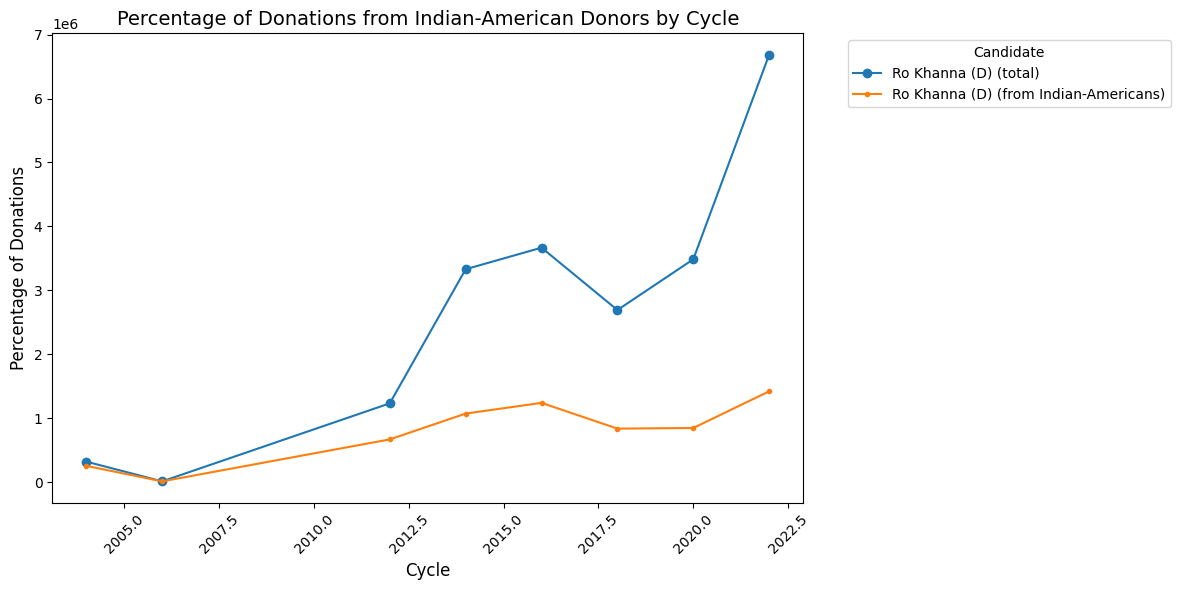

In [66]:
plt.figure(figsize=(12, 6))

# Plot one line per unique name_y
for name in output[output["name_y"].isin(["Ro Khanna (D)"])]["name_y"].unique():
    candidate_data = output[output["name_y"] == name]
    plt.plot(
        candidate_data["cycle"],
        candidate_data["total_raised"],
        marker="o",
        label=name + " (total)"
    )
    plt.plot(
        candidate_data["cycle"],
        candidate_data["raised_from_indian"],
        marker=".",
        label=name + " (from Indian-Americans)"
    )

# Add labels, title, and legend
plt.title("Percentage of Donations from Indian-American Donors by Cycle", fontsize=14)
plt.xlabel("Cycle", fontsize=12)
plt.ylabel("Percentage of Donations", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Candidate", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

In [67]:
donors[(donors["cycle"] == 2020) & (donors["name_y"] == "Raja Krishnamoorthi (D)")][:20]

contrib_id   recip_id                name_new realcode gender  \
19459302  i3003687417   N00033240      ramakrishna kanuri    Z9500      N   
19459352  k00020187951  N00033240               manu shah    Z9500      M   
19460885  q0001232527   N00033240          rama dandamudi    Z9500      N   
19469149  h3001627213@  N00033240           ashley prasad    Y4000      F   
19469612  r0000065881   N00033240            asheesh goel    Z9500      U   
19470480  j1001692029   N00033240              murad alam    Z9500      M   
19472764  i30037790731  N00033240           rishi bhutada    Z9500      M   
19478794  a00010370551  N00033240         babu kantemneni    Z9500      M   
19484808  d0000772392A  N00033240           gloria wexler    Z9500      F   
19487774  k0001103772@  N00033240          alpana loyalka    H2100      F   
19487980  h10011988451  N00033240  sivalingam sivananthan    Y4000      M   
19488813  h10013521451  N00033240            bill s prady    C2100      M   
19489015  h1001501985   N00033240          david p storch    T1300      M   
19489365  i30038111961  N00033240             gagan singh    Z9500      M   
19490336  h3001525039   N00033240           mark ferguson    K1100      M   
19490886  q0001209024   N00033240           ram thukkaram    Y3000      M   
19490982  f0010639199   N00033240             kathy byrne    Z9500      F   
19491356  f00003182411  N00033240         fruman jacobson    X1200      F   
19491721  j1991801911   N00033240         david w johnson    H0000      M   
19491766  h30034870481  N00033240   venkat phd srinivasan    Y4000      M   

                       occupation          city state  total_donated  \
19459302                PHYSICIAN   BROOKSVILLE    FL        22400.0   
19459352               MANAGEMENT        ORANGE    CA        22400.0   
19460885                PRESIDENT       CHICAGO    IL        21200.0   
19469149                HOMEMAKER       GLENCOE    IL        16800.0   
19469612                 ATTORNEY   WILLOWBROOK    IL        16800.0   
19470480                PHYSICIAN       CHICAGO    IL        16200.0   
19472764  VICE PRESIDENT, FINANCE    SUGAR LAND    TX        15000.0   
19478794                PHYSICIAN       DECATUR    AL        13700.0   
19484808             NOT EMPLOYED       GLENCOE    IL        12000.0   
19487774             NOT EMPLOYED       HOUSTON    TX        11200.0   
19487980    CHAIRMAN OF THE BOARD    NAPERVILLE    IL        11200.0   
19488813      TELEVISION PRODUCER   TOLUCA LAKE    CA        11200.0   
19489015                 CHAIRMAN     WOOD DALE    IL        11200.0   
19489365                  BANKING  SADDLE RIVER    NJ        11200.0   
19490336                 ATTORNEY      WINNETKA    IL        11200.0   
19490886             ENTREPRENEUR      GLENVIEW    IL        11200.0   
19490982                   LAWYER       CHICAGO    IL        11200.0   
19491356                 ATTORNEY       CHICAGO    IL        11200.0   
19491721                      CEO       CHICAGO    IL        11200.0   
19491766                 CHAIRMAN        WESTON    MA        11200.0   

          donation_count  ...  ran_general               type cmte_id  \
19459302               5  ...            Y       Other Donors     NaN   
19459352               8  ...            Y  Top 10,000 Donors     NaN   
19460885               5  ...            Y       Other Donors     NaN   
19469149               4  ...            Y       Other Donors     NaN   
19469612               4  ...            Y       Other Donors     NaN   
19470480               5  ...            Y       Other Donors     NaN   
19472764               8  ...            Y       Other Donors     NaN   
19478794               4  ...            Y       Other Donors     NaN   
19484808               9  ...            Y       Other Donors     NaN   
19487774               3  ...            Y       Other Donors     NaN   
19487980               3  ...            Y       Other Donors     NaN   
19488

In [68]:
mean_all_by_year = donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle"])["dem_ratio"].mean()
mean_ind_by_year = donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])[donors["indian"] == True].groupby(["cycle"])["dem_ratio"].mean()

In [69]:
dollar_mean_all_by_year = (
    donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    .groupby(["cycle"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
)
dollar_mean_ind_by_year = (
    donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    [donors["indian"] == True]
    .groupby(["cycle"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
)

In [70]:
dollar_mean_pres_by_year = (
    donors[donors['level'] == 'President']
    .drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    .groupby(["cycle"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
)

dollar_mean_congress_by_year = (
    donors[donors['level'].isin(['House', 'Senate'])]
    .drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    .groupby(["cycle"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
)

dollar_mean_pres_ind_by_year = (
    donors[(donors["indian"] == True) & (donors['level'] == 'President')]
    .drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    .groupby(["cycle"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
)

dollar_mean_congress_ind_by_year = (
    donors[(donors["indian"] == True) & (donors['level'].isin(['House', 'Senate']))]
    .drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    .groupby(["cycle"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
)
dollar_mean_pac_by_year = (
    donors[(donors['recip_is_pac'] == True)]
    .drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    .groupby(["cycle"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
)
dollar_mean_pac_ind_by_year = (
    donors[(donors["indian"] == True) & (donors['recip_is_pac'] == True)]
    .drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    .groupby(["cycle"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
)

In [71]:
count_all_by_year = donors.groupby(["cycle"]).contrib_id.nunique()
count_ind_by_year = donors[donors["indian"] == True].groupby(["cycle"]).contrib_id.nunique()
count_pres_by_year = donors[donors['level'] == 'President'].groupby(["cycle"]).contrib_id.nunique()
count_congress_by_year = donors[donors['level'].isin(['House', 'Senate'])].groupby(["cycle"]).contrib_id.nunique()
count_pres_ind_by_year = donors[(donors["indian"] == True) & (donors['level'] == 'President')].groupby(["cycle"]).contrib_id.nunique()
count_congress_ind_by_year = donors[(donors["indian"] == True) & (donors['level'].isin(['House', 'Senate']))].groupby(["cycle"]).contrib_id.nunique()
count_pac_by_year = donors[(donors['recip_is_pac'] == True)].groupby(["cycle"]).contrib_id.nunique()
count_pac_ind_by_year = donors[(donors["indian"] == True) & (donors['recip_is_pac'] == True)].groupby(["cycle"]).contrib_id.nunique()

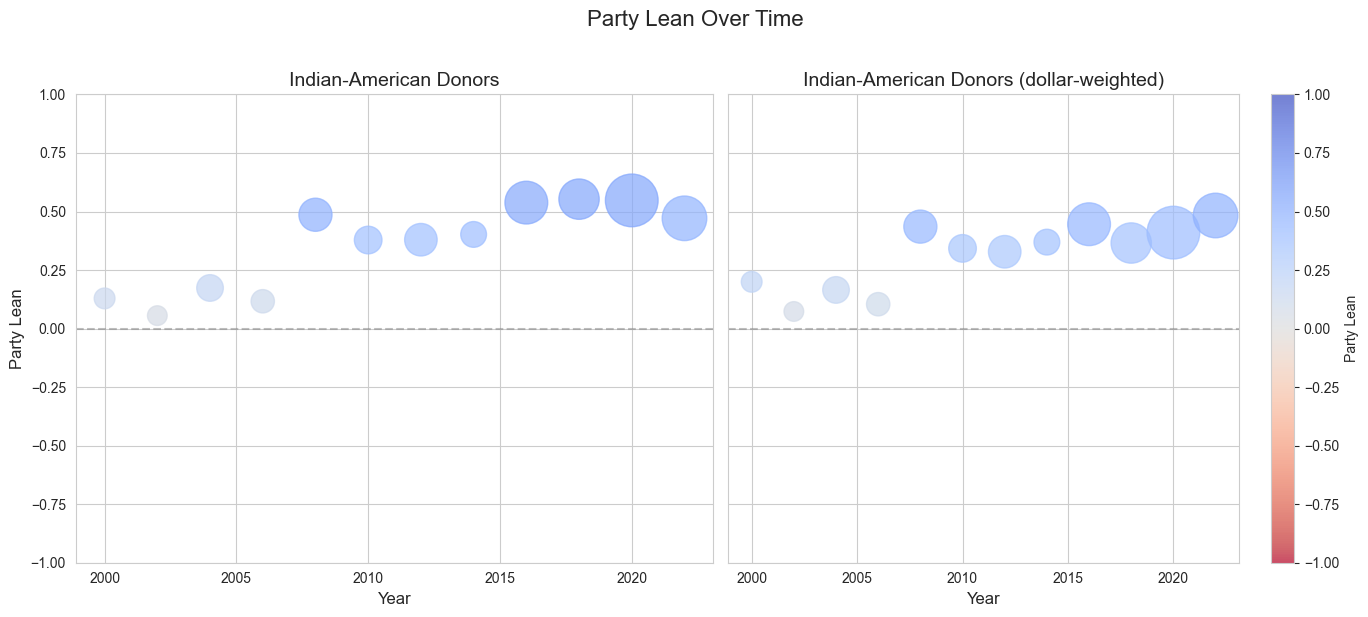

In [84]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")

norm1 = plt.Normalize(-1, 1)
norm2 = plt.Normalize(-1, 1)

sc1 = ax1.scatter(
    mean_ind_by_year.index,
    mean_ind_by_year,
    s=count_ind_by_year / 30,
    c=mean_ind_by_year,
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax1.set_title('Indian-American Donors', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(-1, 1)
ax1.axhline(0, color='gray', linestyle='--', alpha=0.5)

sc2 = ax2.scatter(
    dollar_mean_ind_by_year.index,
    dollar_mean_ind_by_year,
    s=count_ind_by_year / 30,
    c=dollar_mean_ind_by_year,
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax2.set_title('Indian-American Donors (dollar-weighted)', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(-1, 1)
ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)

# Add legend and layout adjustments
cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

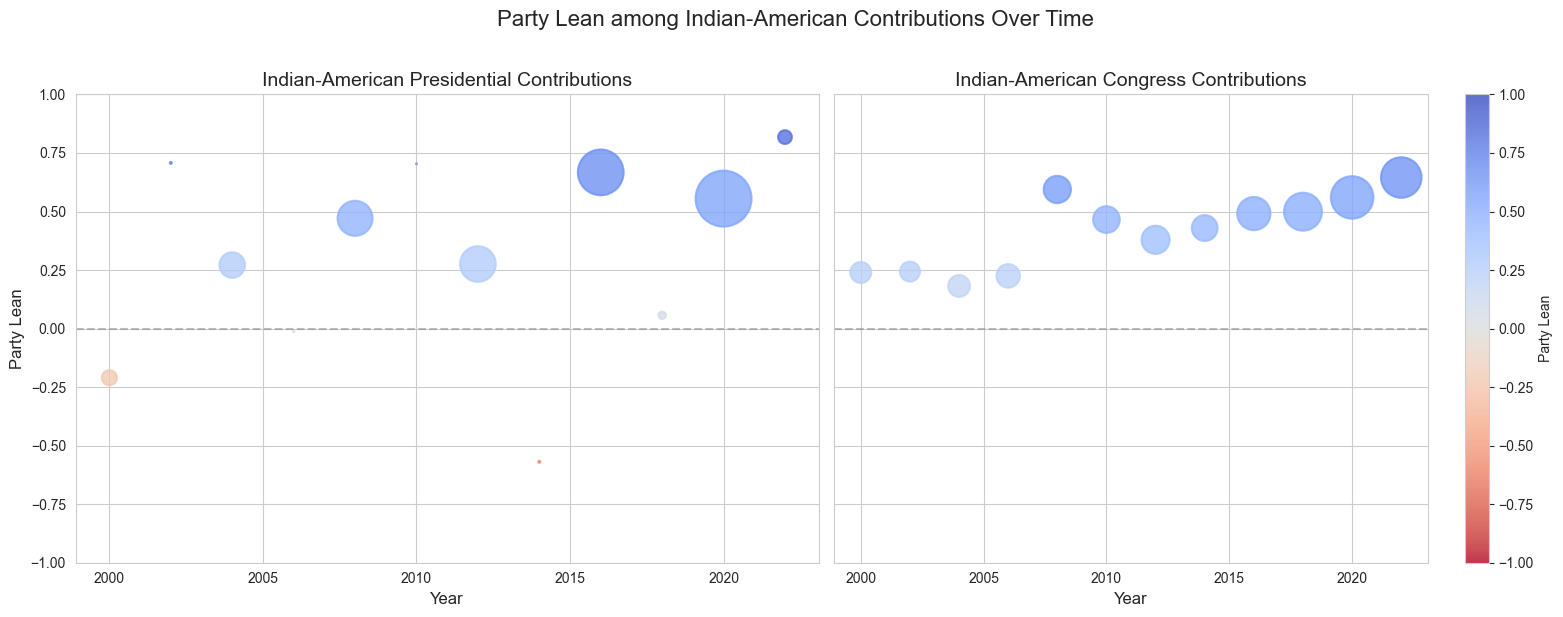

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
sns.set_style("whitegrid")

norm1 = plt.Normalize(-1, 1)

sc1 = ax1.scatter(
    dollar_mean_pres_ind_by_year.index,
    dollar_mean_pres_ind_by_year,
    s=count_pres_ind_by_year / 10,
    c=dollar_mean_pres_ind_by_year,
    cmap=plt.cm.coolwarm_r,
    alpha=0.8,
    norm=norm1,
    label='President',
    linewidths=1.5
)

ax1.set_title('Indian-American Presidential Contributions', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(-1, 1)
ax1.axhline(0, color='gray', linestyle='--', alpha=0.5)
# ax1.legend(sc1.legend_elements()[0], ['President'], loc='upper left', fontsize=10)

sc2 = ax2.scatter(
    dollar_mean_congress_ind_by_year.index,
    dollar_mean_congress_ind_by_year,
    s=count_congress_ind_by_year / 20,
    c=dollar_mean_congress_ind_by_year,
    cmap=plt.cm.coolwarm_r,
    alpha=0.8,
    norm=norm1,
    label='House/Senate',
    linewidths=1.5
)

ax2.set_title('Indian-American Congress Contributions', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(-1, 1)
ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)
# ax2.legend(sc2.legend_elements()[0], ['House/Senate'], loc='upper left', fontsize=10)

cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean among Indian-American Contributions Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

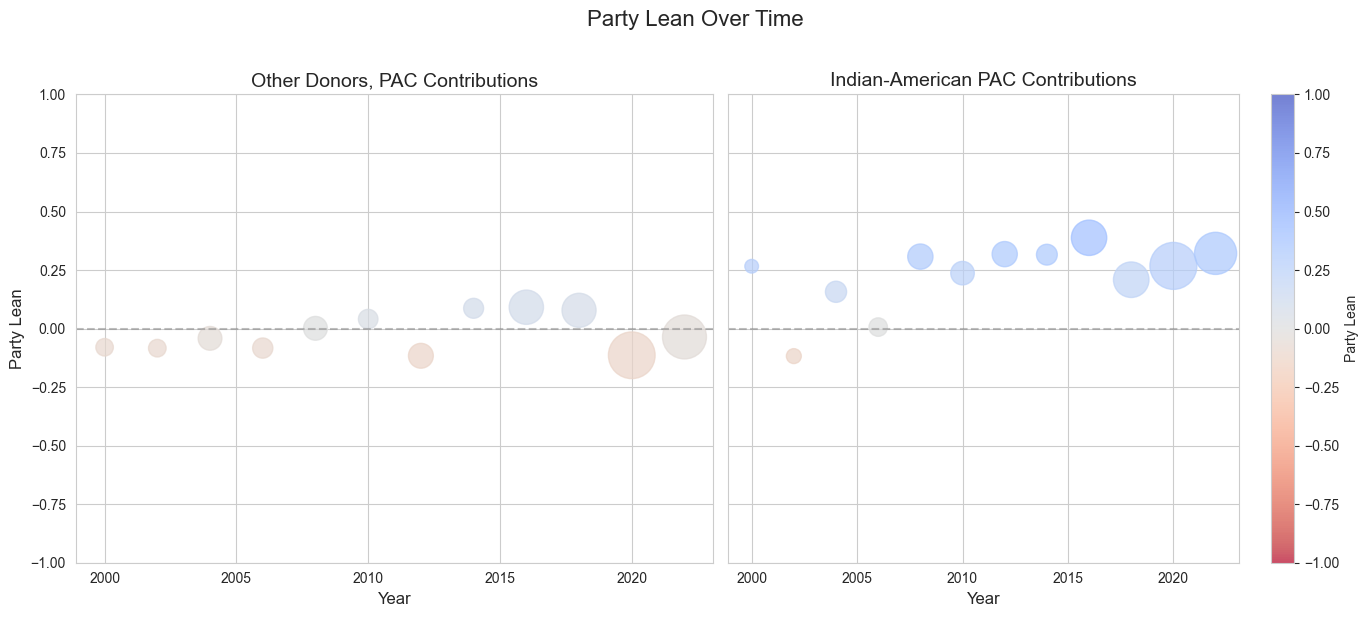

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")

norm1 = plt.Normalize(-1, 1)
norm2 = plt.Normalize(-1, 1)

sc1 = ax1.scatter(
    dollar_mean_pac_by_year.index,
    dollar_mean_pac_by_year,
    s=count_pac_by_year / 2000,
    c=dollar_mean_pac_by_year,
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax1.set_title('Other Donors, PAC Contributions', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(-1, 1)
ax1.axhline(0, color='gray', linestyle='--', alpha=0.5)

sc2 = ax2.scatter(
    dollar_mean_pac_ind_by_year.index,
    dollar_mean_pac_ind_by_year,
    s=count_pac_ind_by_year / 20,
    c=dollar_mean_pac_ind_by_year,
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax2.set_title('Indian-American PAC Contributions', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(-1, 1)
ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)

# Add legend and layout adjustments
cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [75]:
dollar_mean_all = (
    donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    .groupby(["cycle", "sector"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
    .unstack(level='sector')
)
dollar_mean_ind = (
    donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    [donors["indian"] == True]
    .groupby(["cycle", "sector"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
    .unstack(level='sector')
)

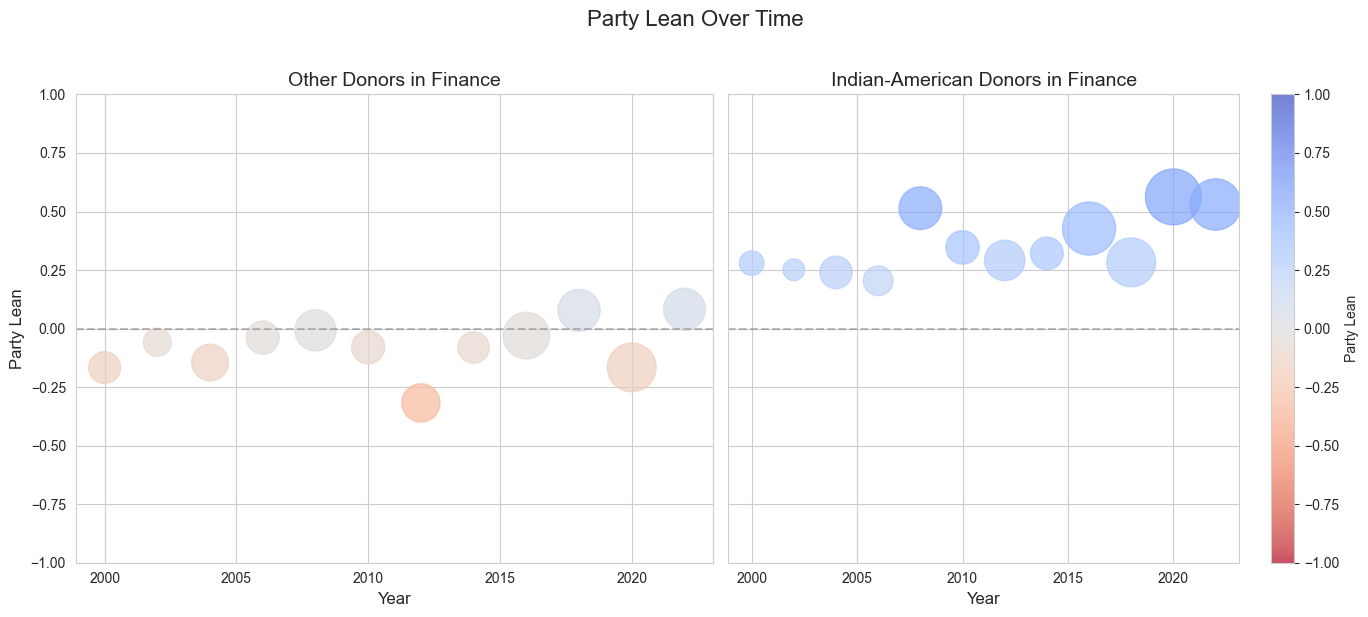

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")

norm1 = plt.Normalize(-1, 1)
norm2 = plt.Normalize(-1, 1)

sc1 = ax1.scatter(
    dollar_mean_all.index,
    dollar_mean_all["Finance"],
    s=donors[(donors["sector"] == "Finance")].groupby(["cycle"])["contrib_id"].nunique() / 200,
    c=dollar_mean_all["Finance"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax1.set_title('Other Donors in Finance', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(-1, 1)
ax1.axhline(0, color='gray', linestyle='--', alpha=0.5)

sc2 = ax2.scatter(
    dollar_mean_ind.index,
    dollar_mean_ind["Finance"],
    s=donors[(donors["indian"] == True) & (donors["sector"] == "Finance")].groupby(["cycle"])["contrib_id"].nunique() / 2,
    c=dollar_mean_ind["Finance"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax2.set_title('Indian-American Donors in Finance', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(-1, 1)
ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)

# Add legend and layout adjustments
cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

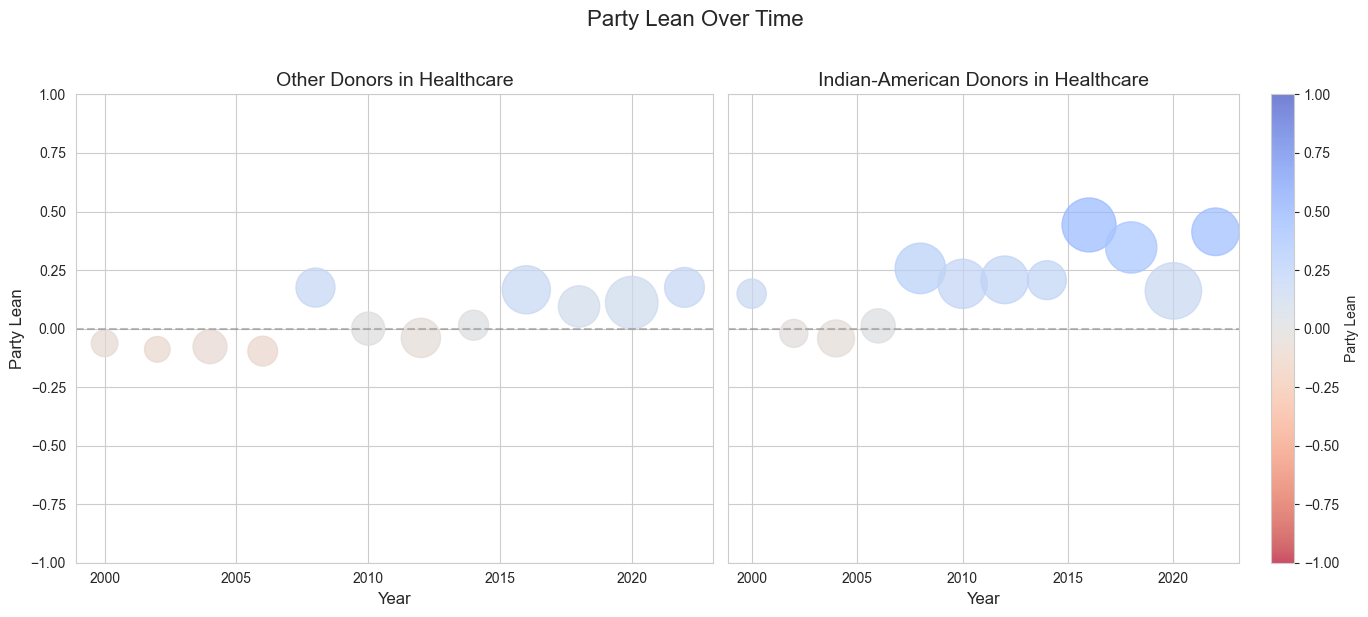

In [77]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")

norm1 = plt.Normalize(-1, 1)
norm2 = plt.Normalize(-1, 1)

sc1 = ax1.scatter(
    dollar_mean_all.index,
    dollar_mean_all["Health"],
    s=donors[(donors["sector"] == "Health")].groupby(["cycle"])["contrib_id"].nunique() / 200,
    c=dollar_mean_all["Health"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax1.set_title('Other Donors in Healthcare', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(-1, 1)
ax1.axhline(0, color='gray', linestyle='--', alpha=0.5)

sc2 = ax2.scatter(
    dollar_mean_ind.index,
    dollar_mean_ind["Health"],
    s=donors[(donors["indian"] == True) & (donors["sector"] == "Health")].groupby(["cycle"])["contrib_id"].nunique() / 4,
    c=dollar_mean_ind["Health"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax2.set_title('Indian-American Donors in Healthcare', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(-1, 1)
ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)

# Add legend and layout adjustments
cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

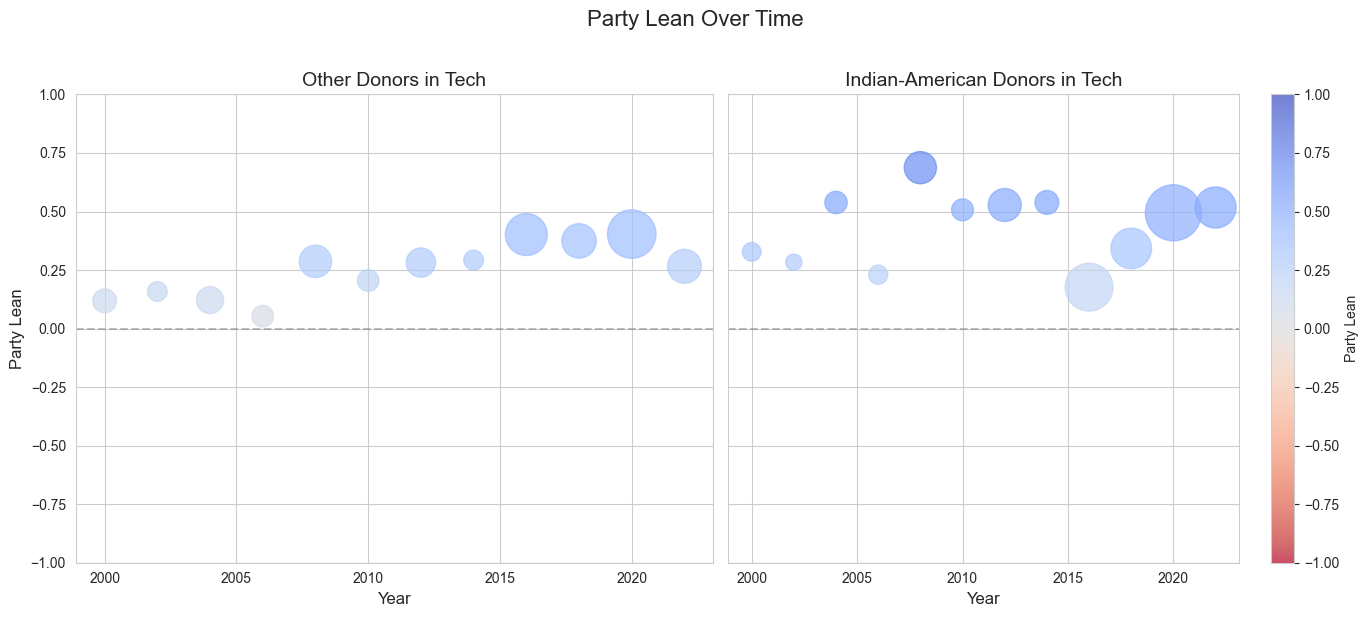

In [78]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")

norm1 = plt.Normalize(-1, 1)
norm2 = plt.Normalize(-1, 1)

sc1 = ax1.scatter(
    dollar_mean_all.index,
    dollar_mean_all["Tech"],
    s=donors[(donors["sector"] == "Tech")].groupby(["cycle"])["contrib_id"].nunique() / 100,
    c=dollar_mean_all["Tech"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax1.set_title('Other Donors in Tech', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(-1, 1)
ax1.axhline(0, color='gray', linestyle='--', alpha=0.5)

sc2 = ax2.scatter(
    dollar_mean_ind.index,
    dollar_mean_ind["Tech"],
    s=donors[(donors["indian"] == True) & (donors["sector"] == "Tech")].groupby(["cycle"])["contrib_id"].nunique() / 2,
    c=dollar_mean_ind["Tech"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax2.set_title('Indian-American Donors in Tech', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(-1, 1)
ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)

# Add legend and layout adjustments
cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [79]:
dollar_mean_pac_ind_by_year

cycle
2000    0.266159
2002   -0.117592
2004    0.157129
2006    0.006375
2008    0.307338
2010    0.236699
2012    0.317964
2014    0.315651
2016    0.387794
2018    0.208664
2020    0.267684
2022    0.321215
dtype: float64

In [80]:
dollar_mean_ind["Finance"]

cycle
2000    0.279365
2002    0.251154
2004    0.239757
2006    0.204247
2008    0.514070
2010    0.346738
2012    0.291070
2014    0.321032
2016    0.427220
2018    0.282787
2020    0.562362
2022    0.529996
Name: Finance, dtype: float64

In [81]:
donors[donors["cycle"] == 2020].groupby("sector")["total_donated"].sum().sort_values(ascending=False)

sector
Party                    3.307925e+09
Unknown                  1.919649e+09
Finance                  1.611668e+09
Ideology/Single Issue    6.250192e+08
Health                   5.996260e+08
Law                      4.325815e+08
Tech                     4.218193e+08
Energy                   1.946185e+08
Construction             1.934803e+08
Transportation           1.913042e+08
Manufacturing            1.741954e+08
Media                    1.300952e+08
Agribusiness             1.260493e+08
Education                6.233092e+07
Labor                    6.089580e+07
Defense                  4.572324e+07
Name: total_donated, dtype: float64

In [82]:
donors[donors["cycle"] == 2000].groupby("sector")["total_donated"].sum().sort_values(ascending=False)

sector
Party                    395851494.0
Unknown                  310372068.0
Finance                  283103490.0
Law                      134163573.0
Tech                     102755714.0
Health                    92821101.0
Ideology/Single Issue     62375218.0
Construction              56086661.0
Transportation            47322655.0
Manufacturing             41277428.0
Energy                    36127860.0
Agribusiness              28951033.0
Labor                      4671133.0
Defense                    4556241.0
Media                      1725278.0
Education                   837785.0
Name: total_donated, dtype: float64

In [83]:
donors[donors["name_new"] == "bharat bhise"].groupby(["cycle", "name_new"])["total_donated"].sum()

cycle  name_new    
2010   bharat bhise      2000.0
2020   bharat bhise    660735.0
2022   bharat bhise    276400.0
Name: total_donated, dtype: float64